In [1]:
#!pip install -r ../requirements.txt

In [3]:
import pandas as pd
import warnings
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from feature_extraction import BoWExtractor, Word2VecEncoder
from data_loader import load_train_test
from pmlb import fetch_data, classification_dataset_names
from collections import Counter
import numpy as np
from PIL import Image
import pickle
import shutil
sns.set()
from scipy import sparse
from viz_utils import *

warnings.filterwarnings('ignore')
data_folder = './results/'
%matplotlib inline

In [9]:
def get_data(encoders, datasets=None, models=None):
    frames = []
    for encoder in encoders:
        d_list = datasets if datasets else os.listdir(os.path.join(data_folder, encoder))
        for dataset in d_list:
            #print(encoder, dataset)
            for result in os.listdir(os.path.join(data_folder, encoder, dataset)):
                if not result.endswith('.csv'):
                    continue
                path = os.path.join(data_folder, encoder, dataset, result)
                strategy, run, model = result.split('_')
                model = model[:-4].replace('.', ',')
                if models is not None and model not in models:
                    continue
                df = pd.read_csv(path)
                df['strategy'] = strategy
                df['restart'] = run
                df['dataset'] = dataset
                df['encoding'] = encoder
                df['model'] = model
                df.drop('ask_ids', axis=1, inplace=True)
                frames.append(df)
    res = pd.concat(frames)
    res.strategy[res.strategy == 'unc'] = 'uncertainty sampling'
    res.encoding[res.encoding == 'word2vec'] = 'skip-gram'
    res['model_type']=res['model'].map(model_type)
    res['regularization_strength'] = res['model'].map(reg_map)
    return res, sorted(res.dataset.unique()), res.encoding.unique(), res.model.unique()

def group_results(res):
    return res.groupby(['core_size', 'strategy', 'dataset', 'model', 'encoding', 'model_type', 'regularization_strength']).mean().reset_index()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22497 entries, 0 to 281
Data columns (total 40 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   core_size                   22497 non-null  int64  
 1   regularization              22497 non-null  float64
 2   test_loss                   22497 non-null  float64
 3   test_accuracy               22497 non-null  float64
 4   test_certainty              22497 non-null  float64
 5   kappa_agreement_test        22497 non-null  float64
 6   test_margin_1               22497 non-null  float64
 7   test_margin_0               22497 non-null  float64
 8   test_f1                     22497 non-null  float64
 9   test_ROC                    22497 non-null  float64
 10  train_loss                  22497 non-null  float64
 11  train_accuracy              22497 non-null  float64
 12  train_certainty             22497 non-null  float64
 13  kappa_agreement_train       22497

In [7]:


def viz(unc=False, core=False, pool=False, model='Regression', alt_name='', datasets=ALL_DATASETS):
    dataset_grouped_df = grouped_bow[(grouped_bow.strategy == 'uncertainty sampling') & (grouped_bow.model == model)].set_index(['dataset'])
    fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(24,24))
    for i, ds in enumerate(datasets):
        sns.set()
        df = dataset_grouped_df.loc[ds].sort_values('core_size')
        p1, p2, baseline = get_proportions(ds, results)
        df['majority_in_core_set'] = p1
        df['majority_in_pool'] = p2
        df = df[df.core_size%30==0]
        ax = axs[i//2][i%2]
        
        max_difference = df.test_acc.max() - df.test_acc.iloc[-1]
        
        if unc:
            ax.plot(df['core_size'], df['certainty'], linestyle='dashed', color='c', linewidth=3, label='certainty')
        
        current = df[['core_size']]
        current['test'] = df['test_acc']
        if core:
            current['core'] = df['current_train_acc']
            ax.plot(df['core_size'], df['majority_in_core_set'], linestyle='dotted', color='y', linewidth=3, label='majority_in_core_set')
        if pool:
            current['pool'] = df['remaining_train_acc']
            #ax.plot(df['core_size'], df['majority_in_pool'], linestyle='dotted', color='r', linewidth=3, label='majority_in_pool')

        current = current.melt('core_size', var_name='accuracy_type',  value_name='accuracy')
        sns_plot = sns.lineplot(x='core_size', y='accuracy', data=current,
                                hue='accuracy_type', hue_order=['core', 'test', 'pool'],
                                ax=ax, size='accuracy_type', sizes=[3]*(1+pool+core))

        sns_plot.plot([-300, max(df['core_size'])+300], [baseline, baseline], color='black', linewidth=0.5, label='naive baseline')
        ax.set_ylabel('test accuracy')    
        ax.set_xlabel('train size')
        sns_plot.set_title(ds+ '. ' + (alt_name if alt_name else model) +'. BoW. Uncertainty sampling')
        sns_plot.text(sns_plot.get_xlim()[1]//4,sns_plot.get_ylim()[1]-0.015,'Max difference in test accuracy: {:.1f}%'.format(max_difference*100))


In [8]:

def svm_viz(gr, datasets=ALL_DATASETS, sharey='row', sharex='none'):
    fig, ax = plt.subplots(len(datasets),3, figsize=(20,4*len(datasets)), sharey=sharey, sharex=sharex)
    sns.set()

    for i, dataset in enumerate(datasets):
        df = gr[(gr.strategy == 'uncertainty sampling') & (gr.dataset == dataset)]

        df = df.sort_values('core_size')
        if 'downsampled' not in dataset:
            baseline = get_baseline(dataset)
        else:
            baseline = get_baseline(dataset[:dataset.index('downsampled') - 1])
        df = df[df.core_size%50==0]
        #max_difference = df.test_acc.max() - df.test_acc.iloc[-1]

        current = df[['core_size']]
        current['test_accuracy'] = df['test_acc']
        current['model_type'] = df['model'].map(lambda x: 'Regression' if x.startswith('Reg') else 
                                                ('svmSquared' if x.startswith('svmLinear') else 'svm'))
        current['model'] = df['model']
        current['regularization_strength'] = df['model'].map(lambda x: reg_map(x))

        sns_plot = sns.lineplot(x='core_size', y='test_accuracy', data=current[current.model_type == 'Regression'],
                                hue='regularization_strength', hue_order=order, ax=ax[i][0])

        sns_plot.plot([-300, max(df['core_size'])+300], [baseline, baseline], color='black', linewidth=0.5, label='naive baseline')
        sns_plot.set_title(dataset + '. Logistic Regression. Test accuracy')
        sns_plot.set_xlabel(' ')
        lines = sns_plot.get_lines()
        lines[5].set_linestyle(':')

        sns_plot = sns.lineplot(x='core_size', y='test_accuracy', data=current[current.model_type == 'svm'],
                                hue='regularization_strength',hue_order=order, ax=ax[i][1])

        sns_plot.plot([-300, max(df['core_size'])+300], [baseline, baseline], color='black', linewidth=0.5, label='naive baseline')
        sns_plot.set_title(dataset + '. SVM. Test accuracy')

        sns_plot.set_xlabel(' ')
        sns_plot = sns.lineplot(x='core_size', y='test_accuracy', data=current[current.model_type == 'svmSquared'],
                                hue='regularization_strength',hue_order=order, ax=ax[i][2])

        sns_plot.plot([-300, max(df['core_size'])+300], [baseline, baseline], color='black', linewidth=0.5, label='naive baseline')
        sns_plot.set_title(dataset + '. SVM(squared hinge). Test accuracy')
        #sns_plot.set_title(ds+ '. ' + model +'. BoW. Uncertainty sampling')
        #sns_plot.text(sns_plot.get_xlim()[1]//3,sns_plot.get_ylim()[1]-0.05,'Max difference in accuracy: {:.1f}%'.format(max_difference*100))
        lines = sns_plot.get_lines()
        lines[5].set_linestyle(':')
        sns_plot.set_xlabel(' ')
    plt.show()

In [9]:
def al_viz(results, grouped, row_variable, column_variable, hue_variable, style_variable, y, viz_baseline):
    sharex = None
    sharey = None
    if len(strategies) != 1:
        if 'strategy' not in [row_variable, column_variable, hue_variable, style_variable]:
            print("Careful, working with 2 strategies without differentiation between them")
    
    if row_variable == column_variable:
        total_plots = grouped[column_variable].nunique()
        if total_plots%2:
            print('UNSUPPORTED OPERATION')
        n_cols = 2
        n_rows = total_plots//2
    else:
        n_cols = grouped[column_variable].nunique() 
        n_rows = grouped[row_variable].nunique()
        sharey = 'row' if column_variable=='dataset'
    
    fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(15,22), sharey=sharey, sharex=sharex)
    
    if row_variable == column_variable: 
        for i, value in enumerate(sorted(grouped[column_variable].unique())):
            current = grouped[grouped[column_variable] == value]
            sns_plot = sns.lineplot(x='core_size', y='test_acc', 
                        hue=hue_variable,#hue_order=['fasttext', 'bow'], 
                        data=current, style=style_variable,# style_order=['random', 'uncertainty sampling'],
                        ax=axs[i//n_cols][i%n_cols])
            if viz_baseline:
                if len(current.dataset.unique()) > 1:
                    print('Error, baselining several datasets.')
                    continue
                baseline = current.iloc[-1].core_majority.values[0]
                sns_plot.plot([-300, max(current['core_size'])+300], [baseline, baseline], color='black', linewidth=0.5)
                sns_plot.set_title(value)
                sns_plot.set_xlabel('')

SyntaxError: invalid syntax (<ipython-input-9-2f0c44bd1296>, line 19)

In [11]:
#results['accuracy'] = results['test_acc']
#results = results.drop('test_acc', axis=1)
#results = get_data(['glove', 'fasttext', 'word2vec', 'cbow', 'bow'])
results, datasets, encoders, models = get_data(['glove', 'fasttext', 'word2vec', 'cbow', 'bow'], ALL_DATASETS, ['Regression'])
results.tail()

grouped = group_results(results)

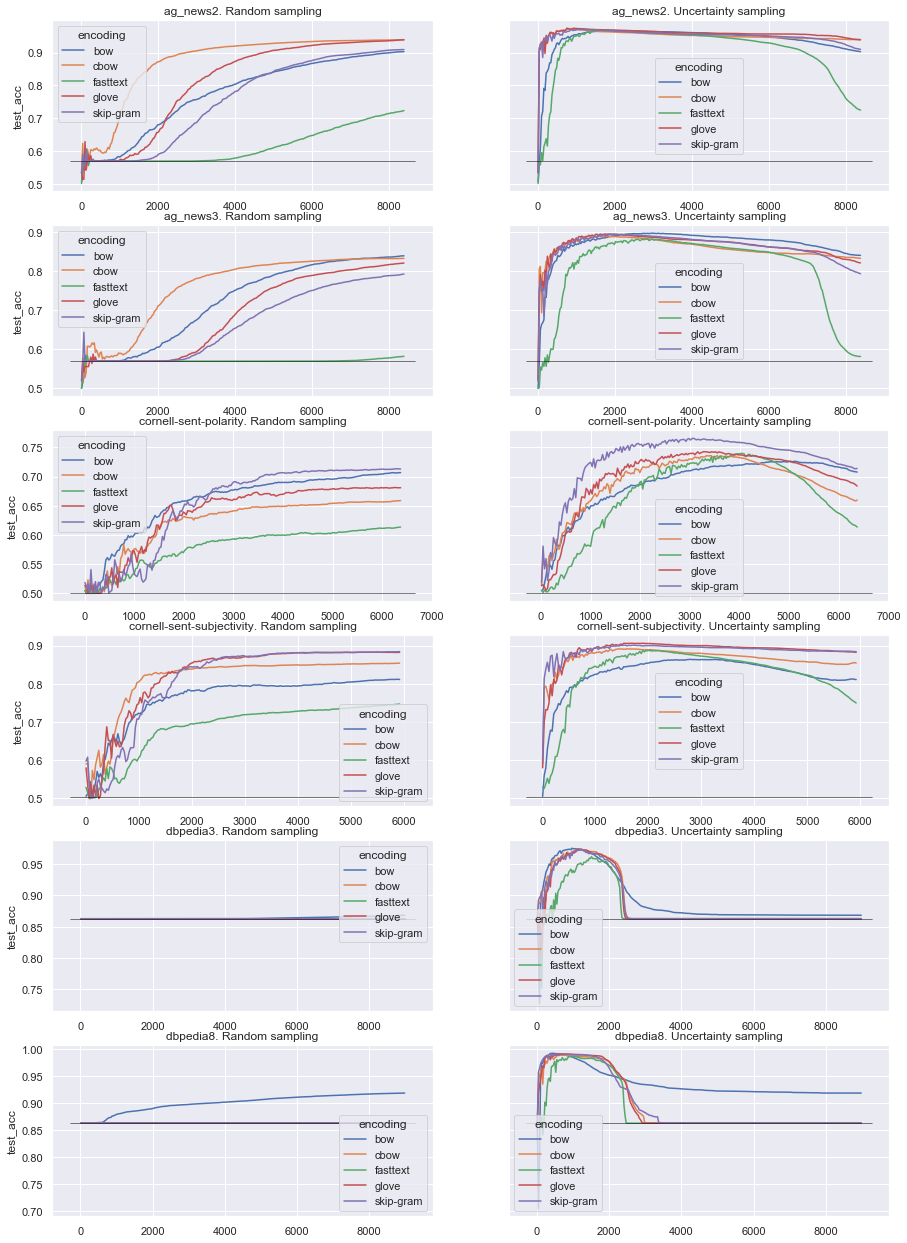

In [23]:
current = grouped[grouped.model == 'Regression'].reset_index().set_index(['dataset'])
def cut_current(some_df):
    return some_df[some_df.core_size%30 == 10]
fig, axs = plt.subplots(ncols=2, nrows=len(datasets), figsize=(15,22), sharey='row')
sns.set()
for i, ds in enumerate(datasets):
    df = cut_current(current).loc[ds]
    index = (df.strategy == 'random')#(df.encoding == 'glove') | (df.encoding == 'cbow') | (df.encoding == 'skip-gram')
    sns_plot = sns.lineplot(x='core_size', y='test_acc', 
                            hue='encoding',#hue_order=['fasttext', 'bow'], 
                            data=df[~index], #style='strategy', style_order=['random', 'uncertainty sampling'],
                            ax=axs[i][1])
    
    baseline = get_baseline(ds)
    sns_plot.plot([-300, max(df['core_size'])+300], [baseline, baseline], color='black', linewidth=0.5)
    sns_plot.set_title(ds + '. Uncertainty sampling')
    sns_plot.set_xlabel('')
    sns_plot = sns.lineplot(x='core_size', y='test_acc', 
                            hue='encoding',#hue_order=['fasttext', 'bow'], 
                            data=df[index], #style='strategy', style_order=['random', 'uncertainty sampling'],
                            ax=axs[i][0])
    """sns_plot = sns.lineplot(x='core_size', y='test_acc', 
                            hue='encoding',hue_order=['glove', 'skip-gram', 'cbow'], 
                            data=df[index], style='strategy', style_order=['random', 'uncertainty sampling'], ax=axs[i][0],
                           palette=sns.color_palette(["#9b59b6",  "#e74c3c",  "#2ecc71"]))"""
    sns_plot.set_title(ds + '. Random sampling')
    sns_plot.set_xlabel('')
    sns_plot.plot([-300, max(df['core_size'])+300], [baseline, baseline], color='black', linewidth=0.5)
    #plt.show()

# BoW viz

In [123]:

results, datasets, encoders, models = get_data(['bow'], ALL_DATASETS)
grouped_bow = group_results(results)
grouped_bow.head()

bow cornell-sent-polarity
bow cornell-sent-subjectivity
bow ag_news2
bow ag_news3
bow dbpedia3
bow dbpedia8


core_size algorithm                dataset       model encoding  test_acc  \
0       10.0    random               ag_news2  Regression      bow  0.506679   
1       10.0    random               ag_news2   svmLinear      bow  0.507179   
2       10.0    random               ag_news3  Regression      bow  0.499786   
3       10.0    random               ag_news3   svmLinear      bow  0.500268   
4       10.0    random  cornell-sent-polarity  Regression      bow  0.504689   

   ask_id  current_train_acc  remaining_train_acc  support_vectors  w_norm  \
0    -1.0               0.71             0.506889             -1.0    -1.0   
1    -1.0               0.71             0.507354             -1.0    -1.0   
2    -1.0               0.71             0.499178             -1.0    -1.0   
3    -1.0               0.72             0.499845             -1.0    -1.0   
4    -1.0               0.74             0.504697             -1.0    -1.0   

   total_loss  avg_loss  certainty  
0        -1.0      -1.0   0.659890  
1        -1.0      -1.0   0.575279  
2        -1.0      -1.0   0.660129  
3        -1.0      -1.0   0.573784  
4        -1.0      -1.0   0.640518

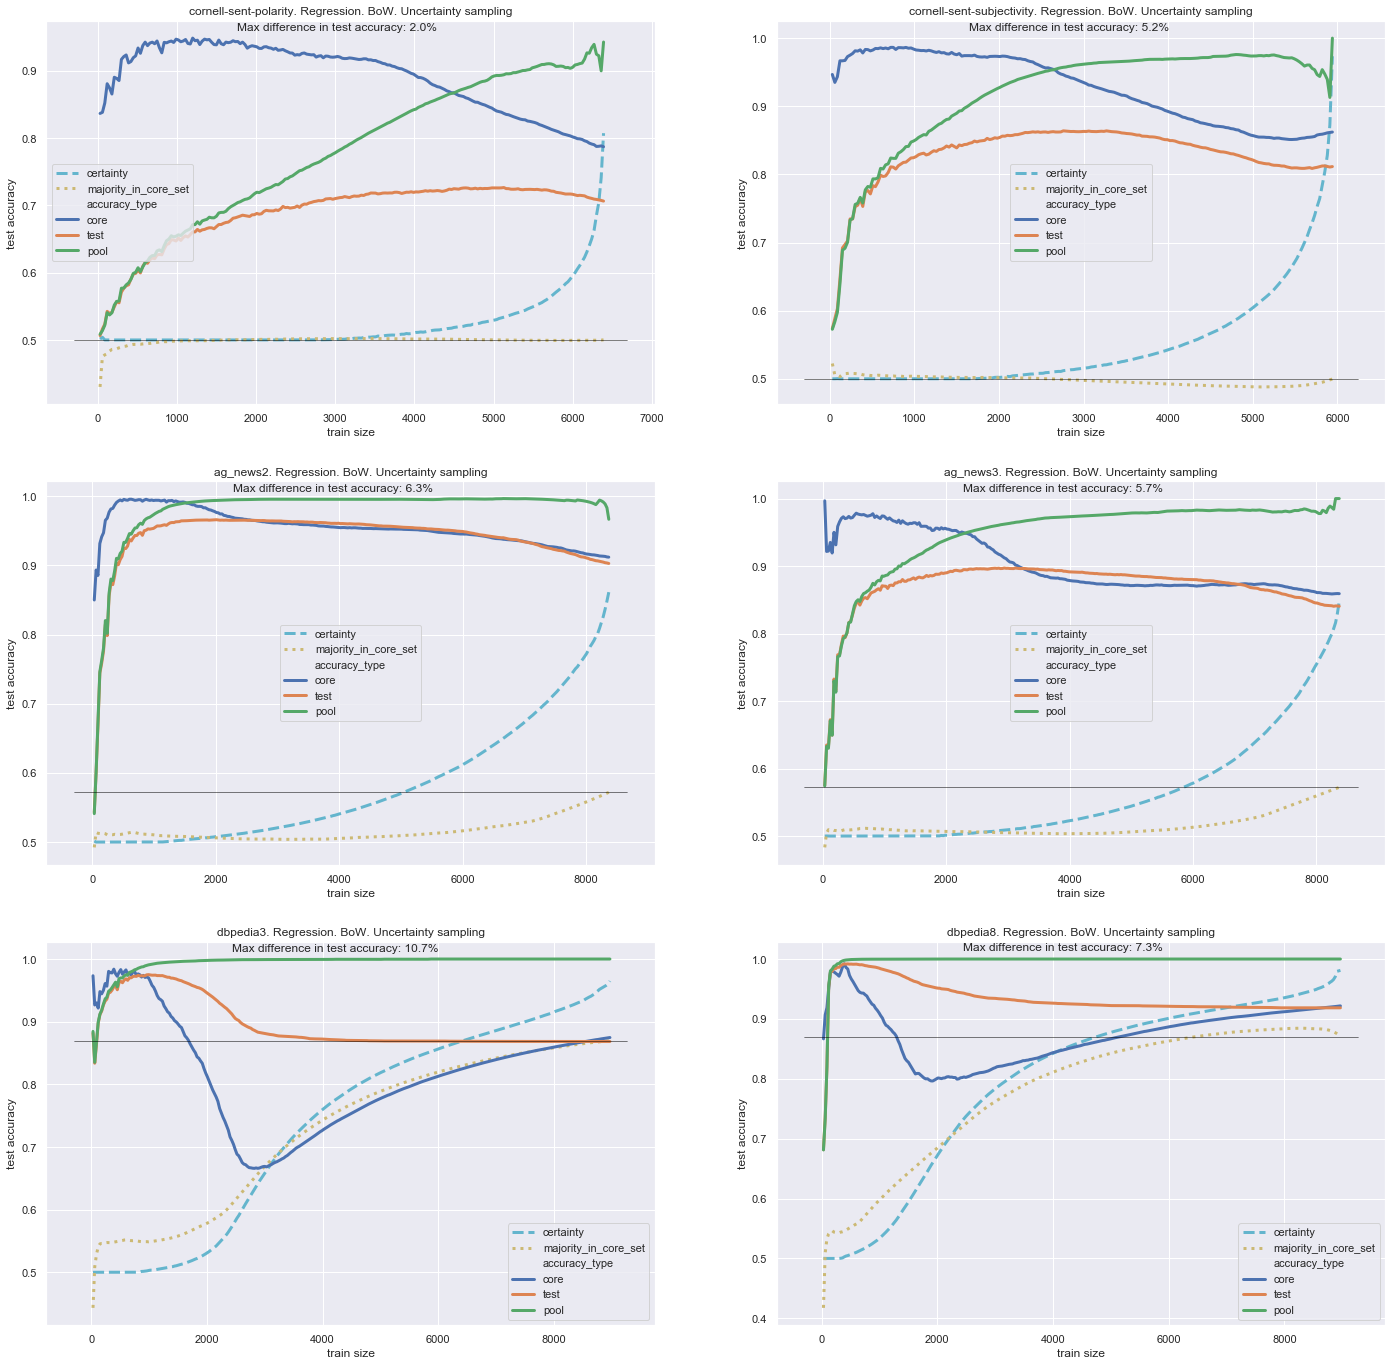

In [130]:
viz(True, True, True, 'Regression')

cornell-sent-polarity 0.14048783060129907 7.118054252243206
cornell-sent-subjectivity 0.11223871456709139 8.909581723713021
ag_news2 0.060506748352641714 16.52708213919977
ag_news3 0.05946270223568107 16.81726464492799
dbpedia3 0.06120792547926875 16.337753520803478
dbpedia8 0.06395030614020362 15.63714171762706


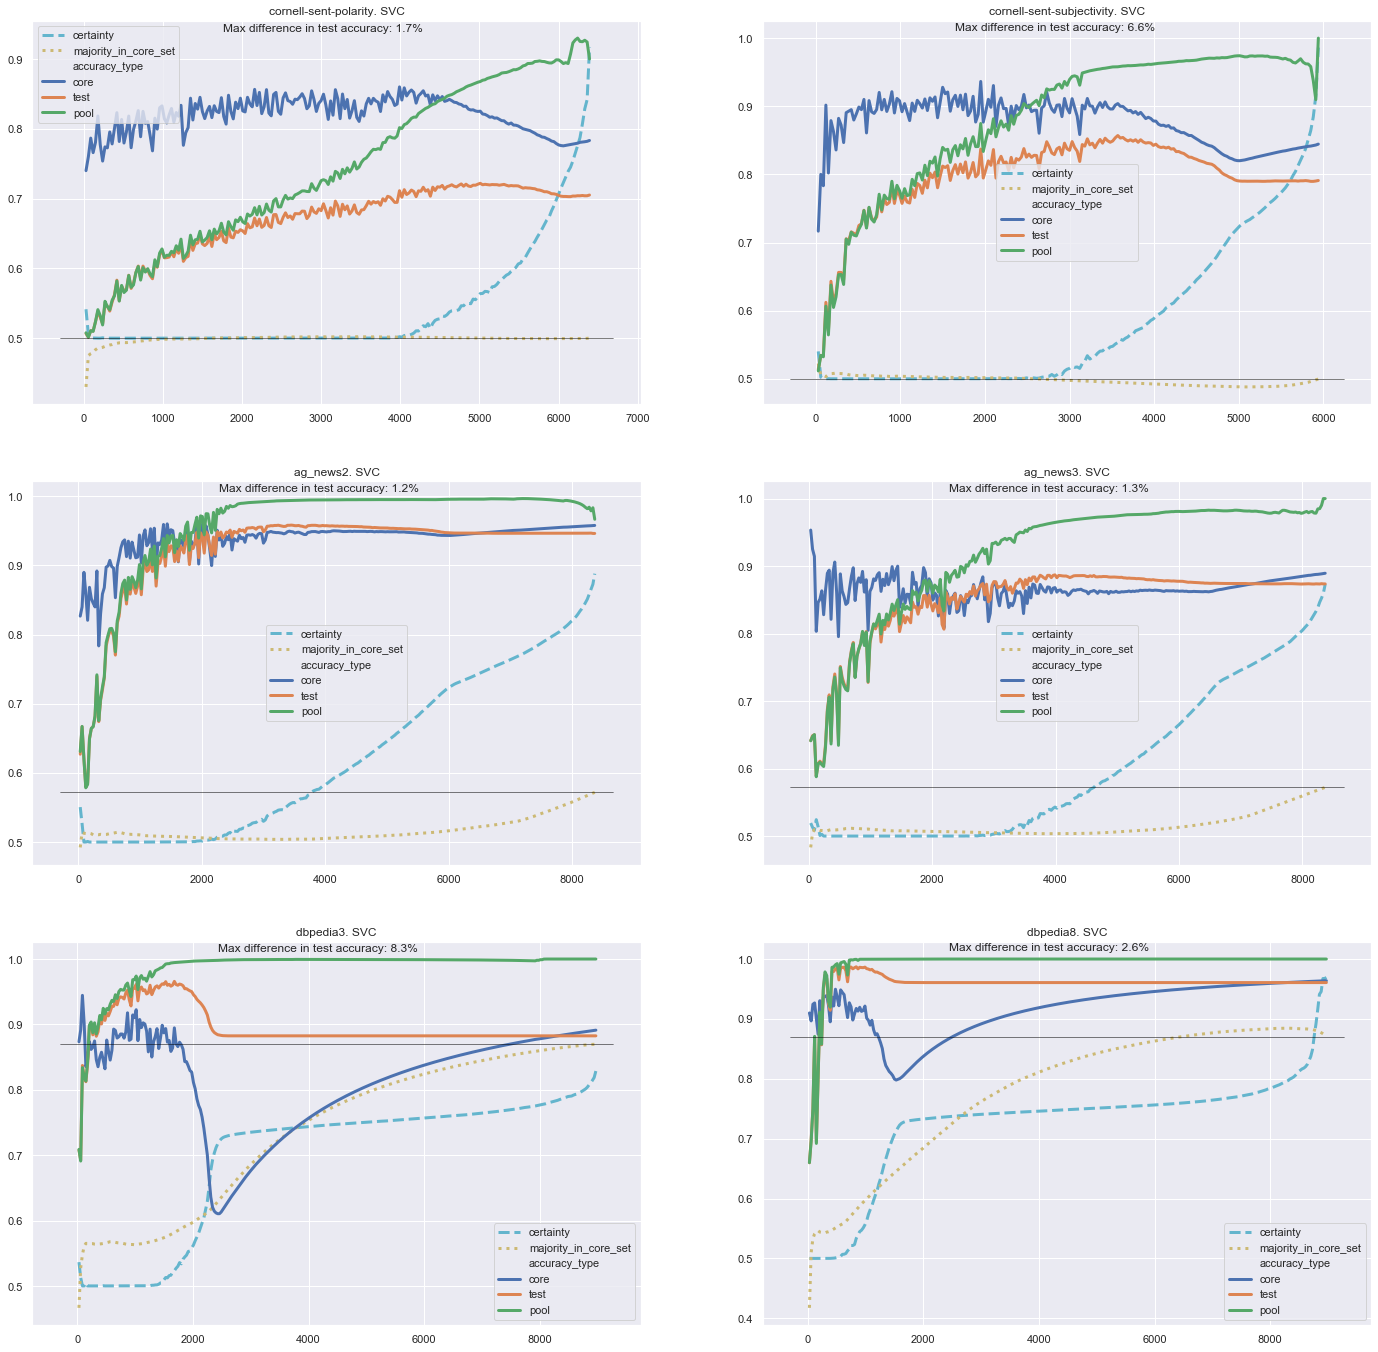

In [124]:
viz(True, True, True, 'svmHinge', 'SVC')

cornell-sent-polarity 0.14048783060129907 7.118054252243206
cornell-sent-subjectivity 0.11223871456709139 8.909581723713021
ag_news2 0.060506748352641714 16.52708213919977
ag_news3 0.05946270223568107 16.81726464492799
dbpedia3 0.06120792547926875 16.337753520803478
dbpedia8 0.06395030614020362 15.63714171762706


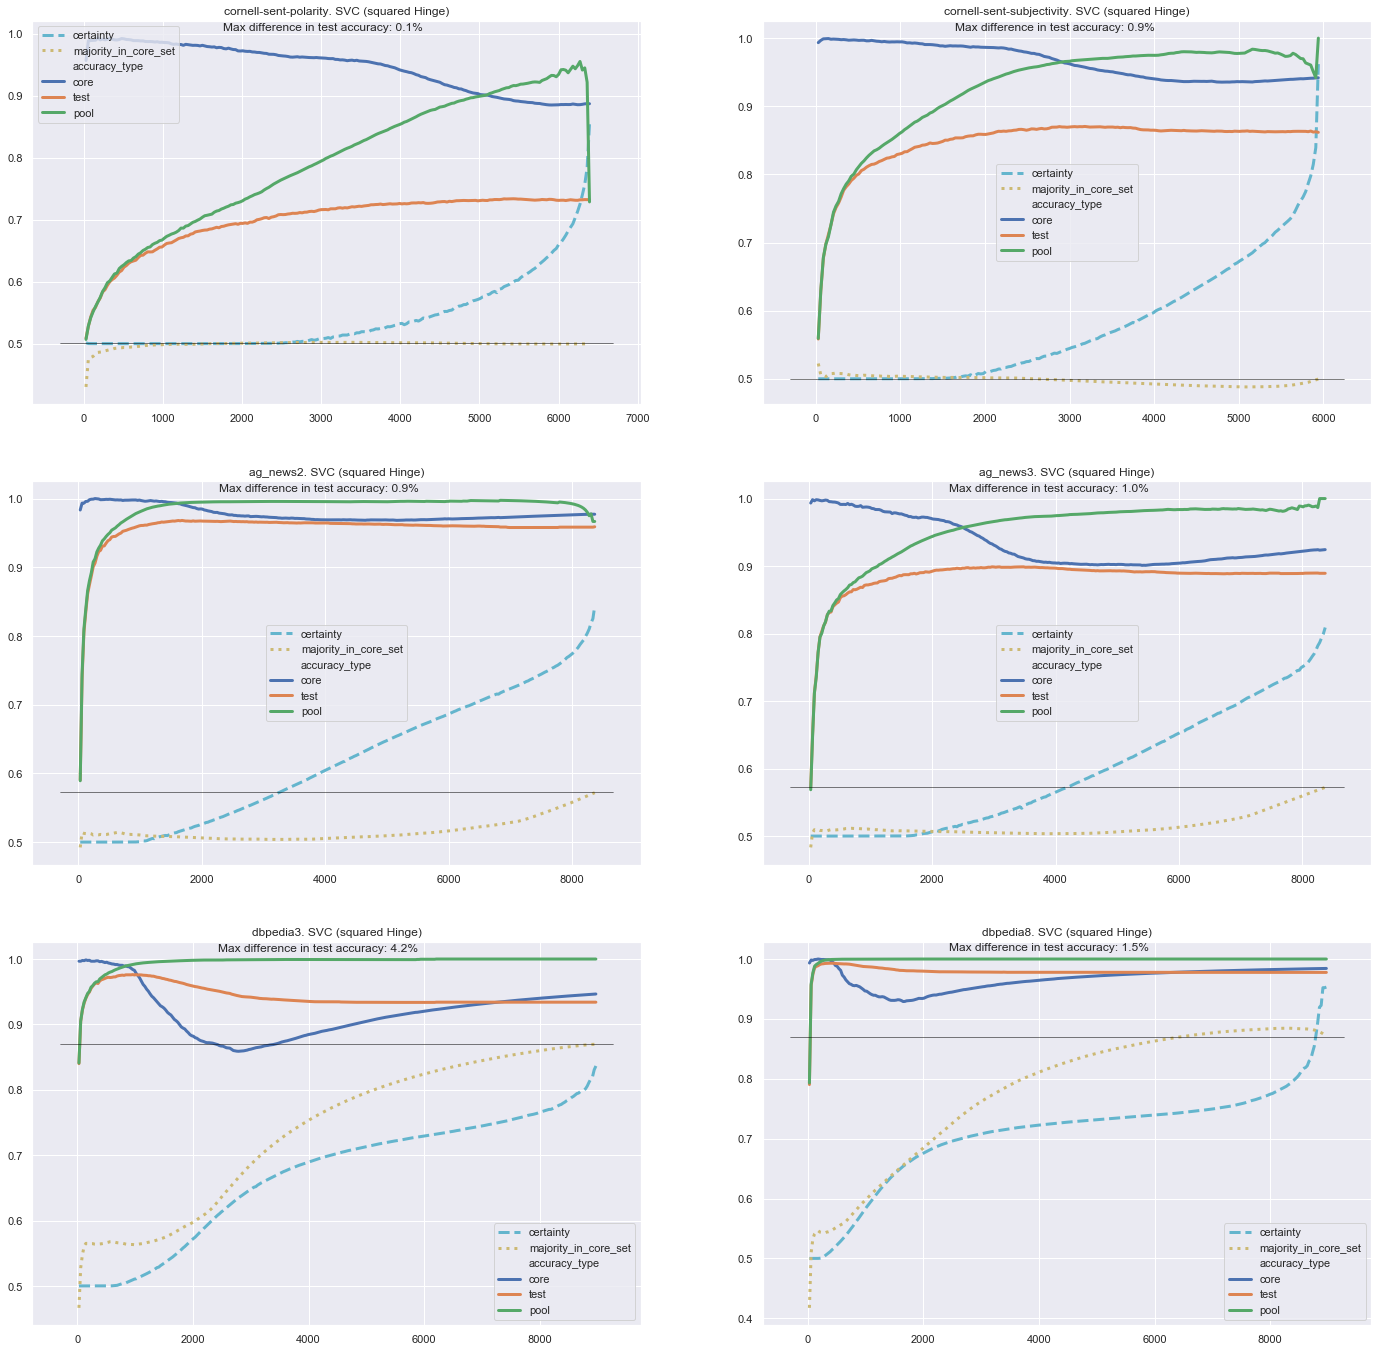

In [125]:
viz(True, True, True, 'svmLinear', 'SVC (squared Hinge)')

<h3> SVM viz </h3>

cornell-sent-polarity 0.14048783060129907 7.118054252243206
cornell-sent-subjectivity 0.11223871456709139 8.909581723713021
ag_news2 0.060506748352641714 16.52708213919977
ag_news3 0.05946270223568107 16.81726464492799
dbpedia3 0.06120792547926875 16.337753520803478
dbpedia8 0.06395030614020362 15.63714171762706


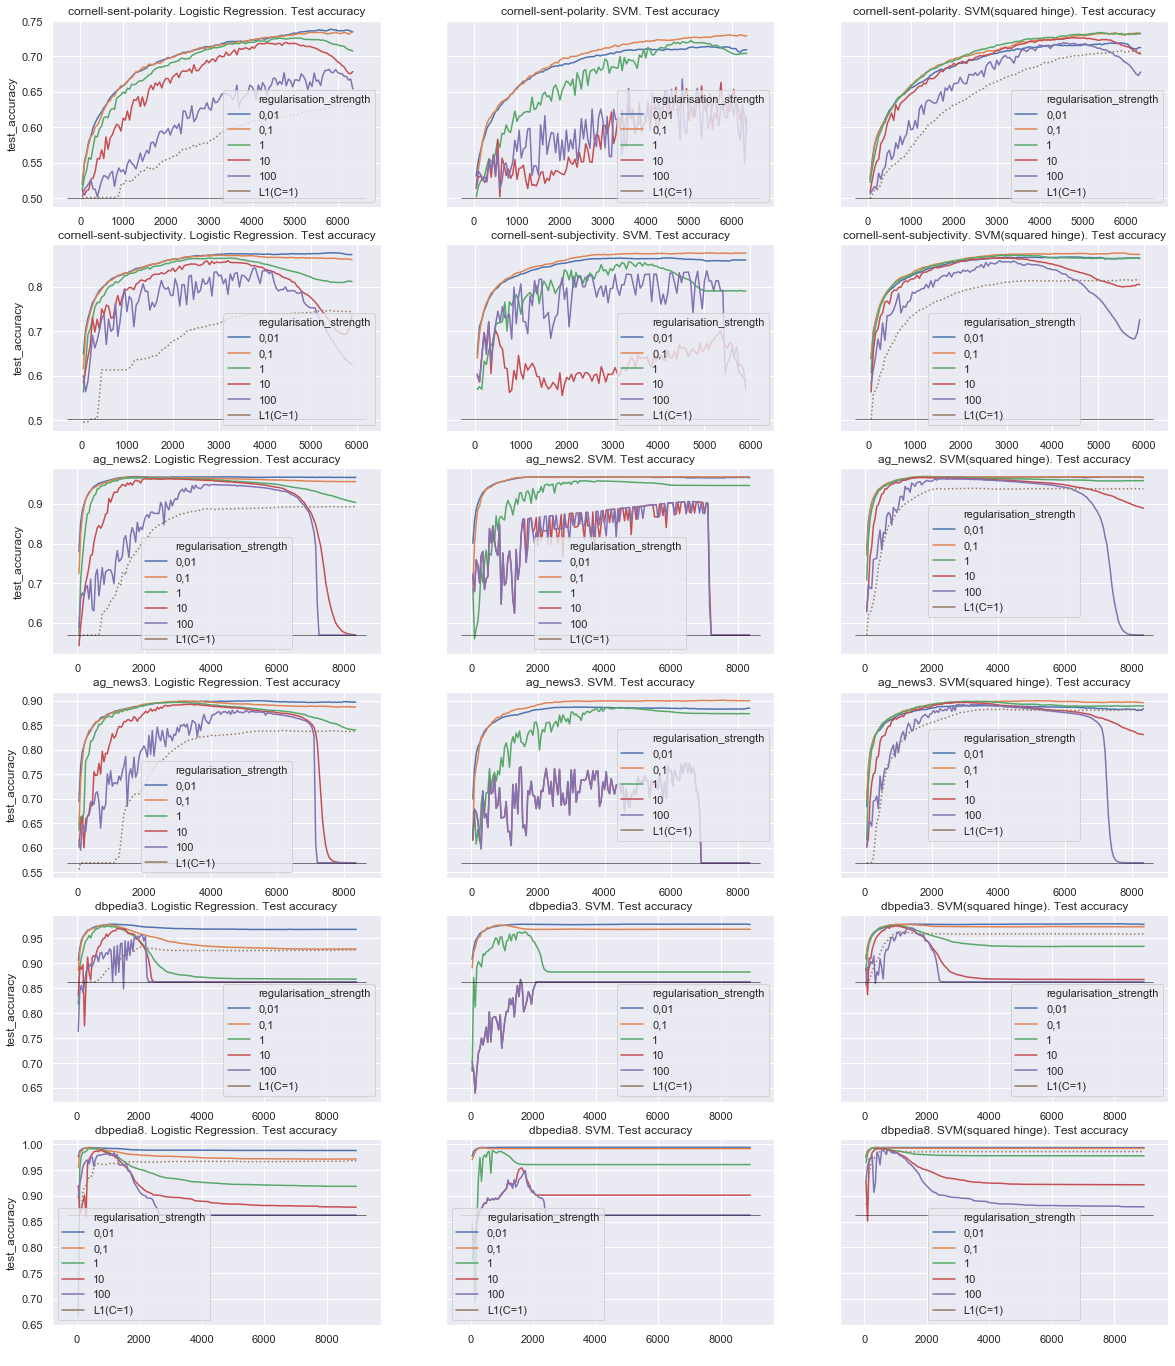

In [153]:
svm_viz(grouped_bow)

dbpedia3 0.06120792547926875 16.337753520803478
dbpedia3 0.06120792547926875 16.337753520803478
dbpedia3 0.06120792547926875 16.337753520803478


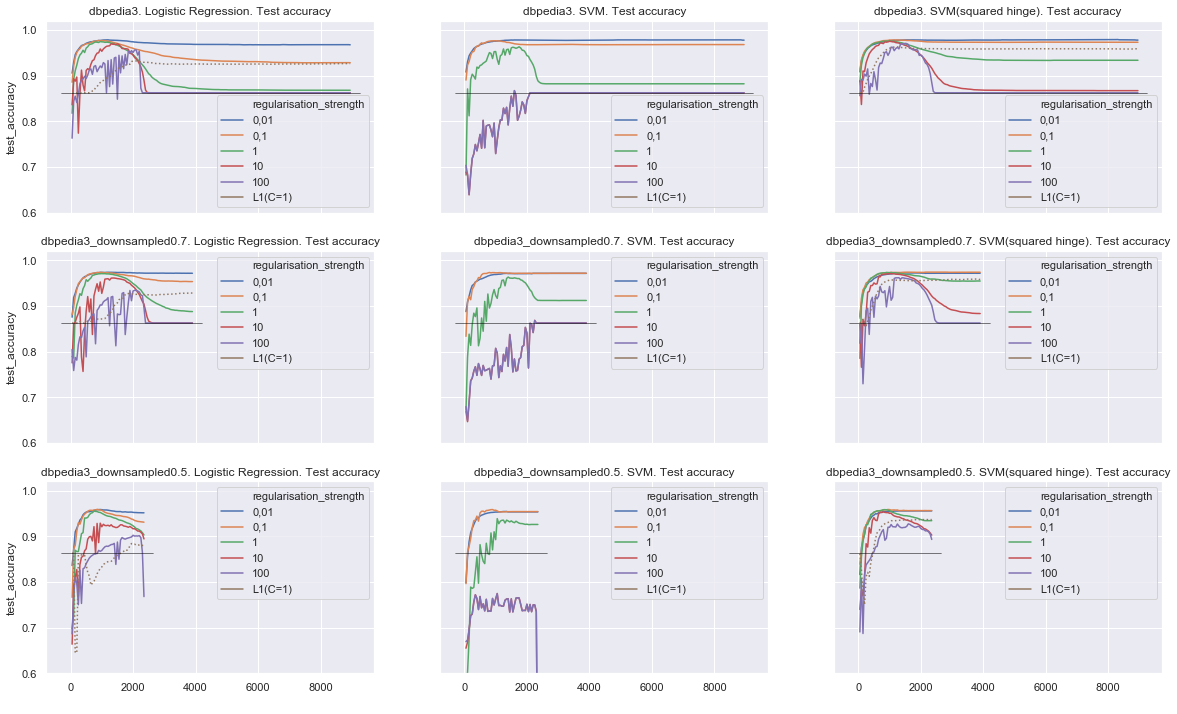

In [149]:
#res = get_data(['bow'], ['dbpedia3', 'dbpedia3_downsampled0.7', 'dbpedia3_downsampled0.5'])
#gr = res.groupby(['core_size', 'strategy', 'dataset', 'model']).mean().reset_index()
svm_viz(['dbpedia3', 'dbpedia3_downsampled0.7', 'dbpedia3_downsampled0.5'], gr, 'all', 'col')

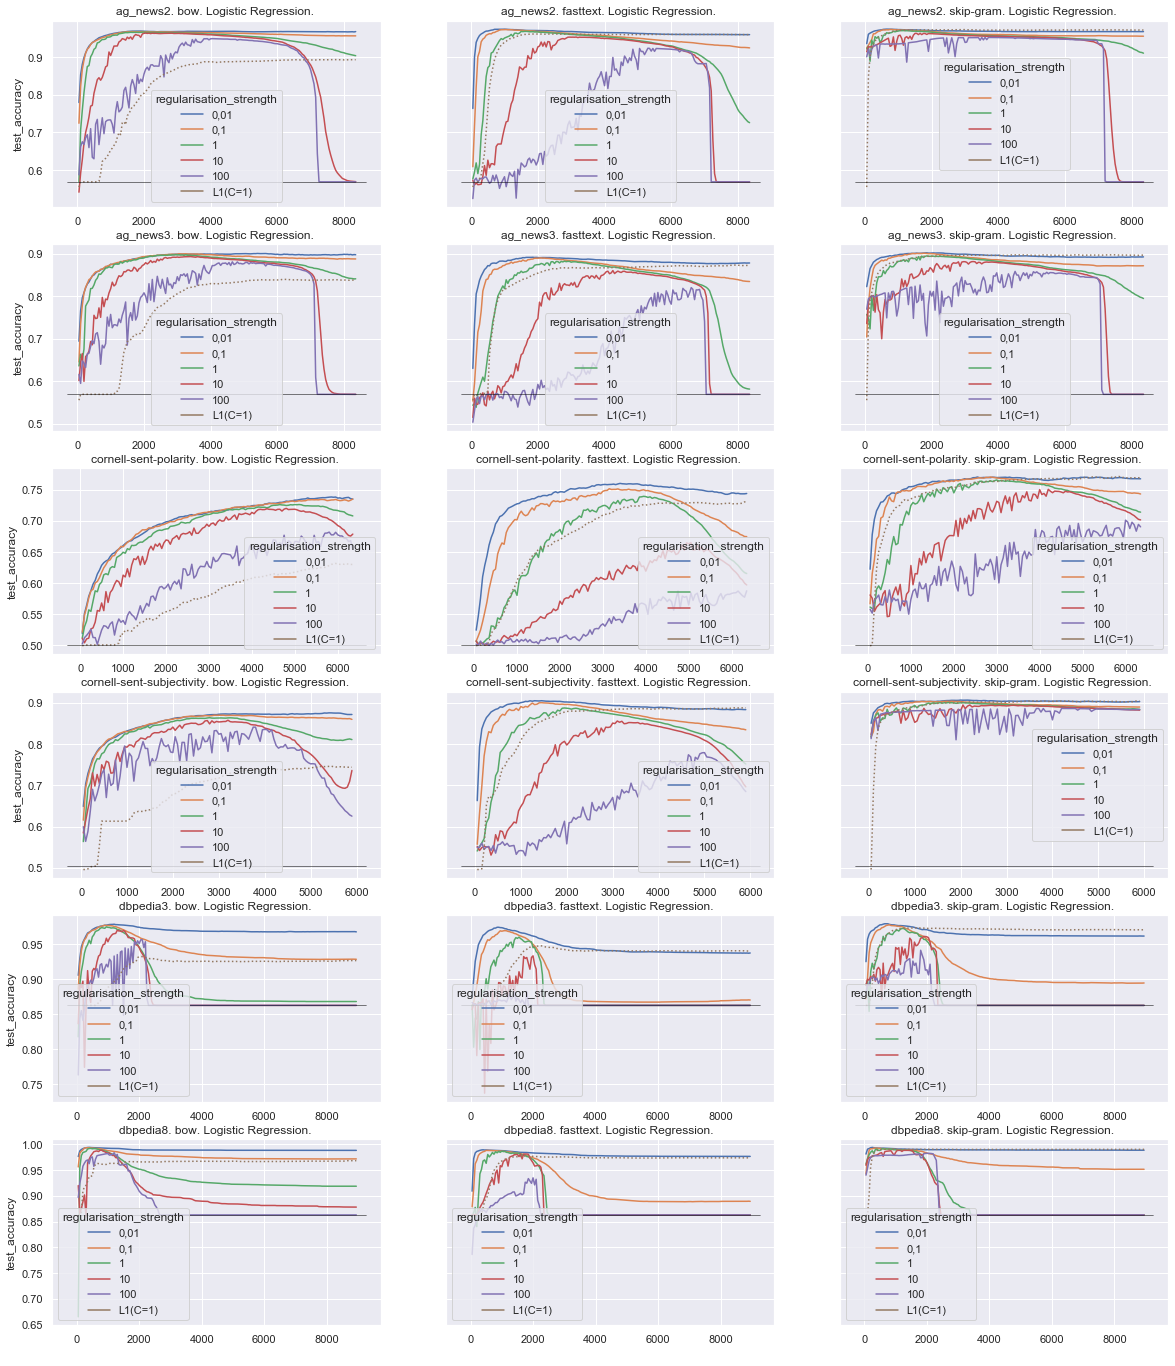

In [50]:
results, datasets, encoders, models = get_data(['fasttext', 'word2vec', 'bow'], ALL_DATASETS)
grouped_fst = group_results(results)
fig, ax = plt.subplots(len(datasets),3, figsize=(20,4*len(datasets)), sharey='row')
sns.set()
gr = grouped_fst

#order_ = [str(x).replace('.', ',') for x in [0.01, 0.1,  1, 10, 100, 'L1']]
gr['model_type'] = gr['model'].map(lambda x: 'Regression' if x.startswith('Reg') else 
                                            ('svmSquared' if x.startswith('svmLinear') else 'svm'))
gr['regularization_strength'] = gr['model'].map(lambda x: reg_map(x))
for i, dataset in enumerate(sorted(datasets)):
    df = gr[(gr.strategy == 'uncertainty sampling') & (gr.dataset == dataset) & (gr.model_type == 'Regression')]
    df = df[df.core_size%50==0]
    df = df.sort_values('core_size')
    if 'downsampled' not in dataset:
        baseline = get_baseline(dataset)
    else:
        baseline = get_baseline(dataset[:dataset.index('downsampled') - 1])
    
    #max_difference = df.test_acc.max() - df.test_acc.iloc[-1]

    current = df[['core_size', 'encoding', 'model', 'regularization_strength']]
    current['test_accuracy'] = df['test_acc']

    for j, enc in enumerate(sorted(encoders)):
    
        sns_plot = sns.lineplot(x='core_size', y='test_accuracy', data=current[current.encoding == enc],
                                hue='regularization_strength', hue_order=order, ax=ax[i][j])

        sns_plot.plot([-300, max(df['core_size'])+300], [baseline, baseline], color='black', linewidth=0.5, label='naive baseline')
        sns_plot.set_title(dataset + '. ' +enc +'. Logistic Regression. ')
        sns_plot.set_xlabel(' ')
        lines = sns_plot.get_lines()
        lines[5].set_linestyle(':')


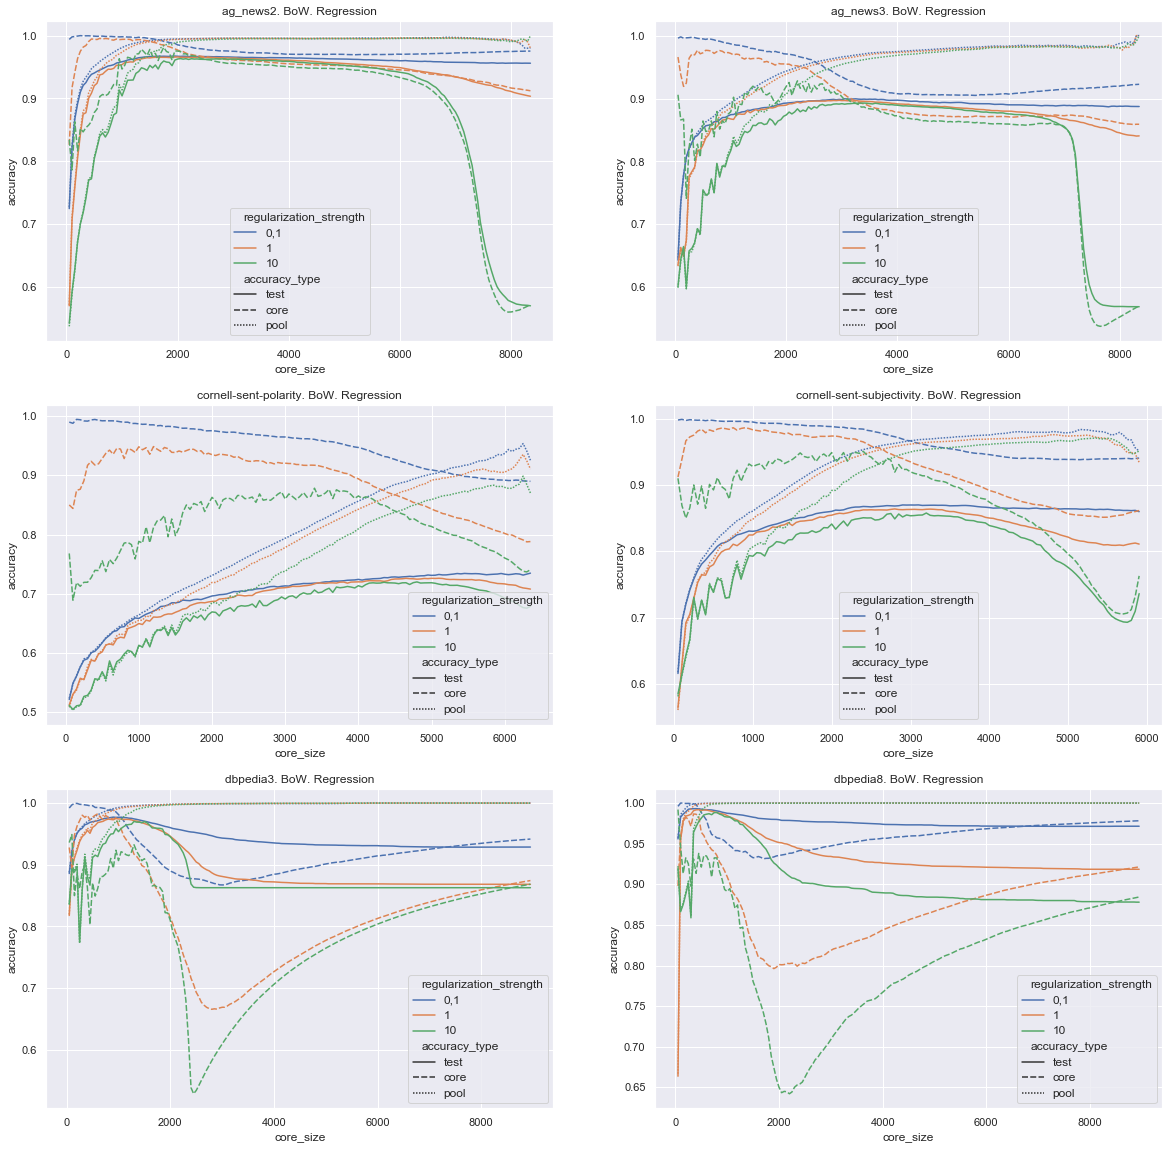

In [22]:
results, datasets, encoders, models = get_data(['bow'], ALL_DATASETS, ['Regression', 'Regression0,1', 'Regression10'])
grouped_fst = group_results(results)
fig, ax = plt.subplots(3,2, figsize=(20,20))
sns.set()
gr = grouped_fst
gr['regularization_strength'] = gr['model'].map(lambda x: reg_map(x))
for i, dataset in enumerate(sorted(datasets)):
    df = gr[(gr.dataset == dataset) & (gr.strategy == 'uncertainty sampling')]
    df = df[df.core_size%50==0]
    
    #max_difference = df.test_acc.max() - df.test_acc.iloc[-1]

    current = df[['core_size', 'regularization_strength']]

    current['test'] = df['test_acc']
    current['core'] = df['current_train_acc']
    current['pool'] = df['remaining_train_acc']
    current = current.melt(['core_size', 'regularization_strength'], var_name='accuracy_type',  value_name='accuracy')
    sns_plot = sns.lineplot(x='core_size', y='accuracy', data=current,
                            hue='regularization_strength', style='accuracy_type', hue_order=['0,1', '1', '10'], ax=ax[i//2][i%2])
    sns_plot.set_title('{}. BoW. Regression'.format(dataset))


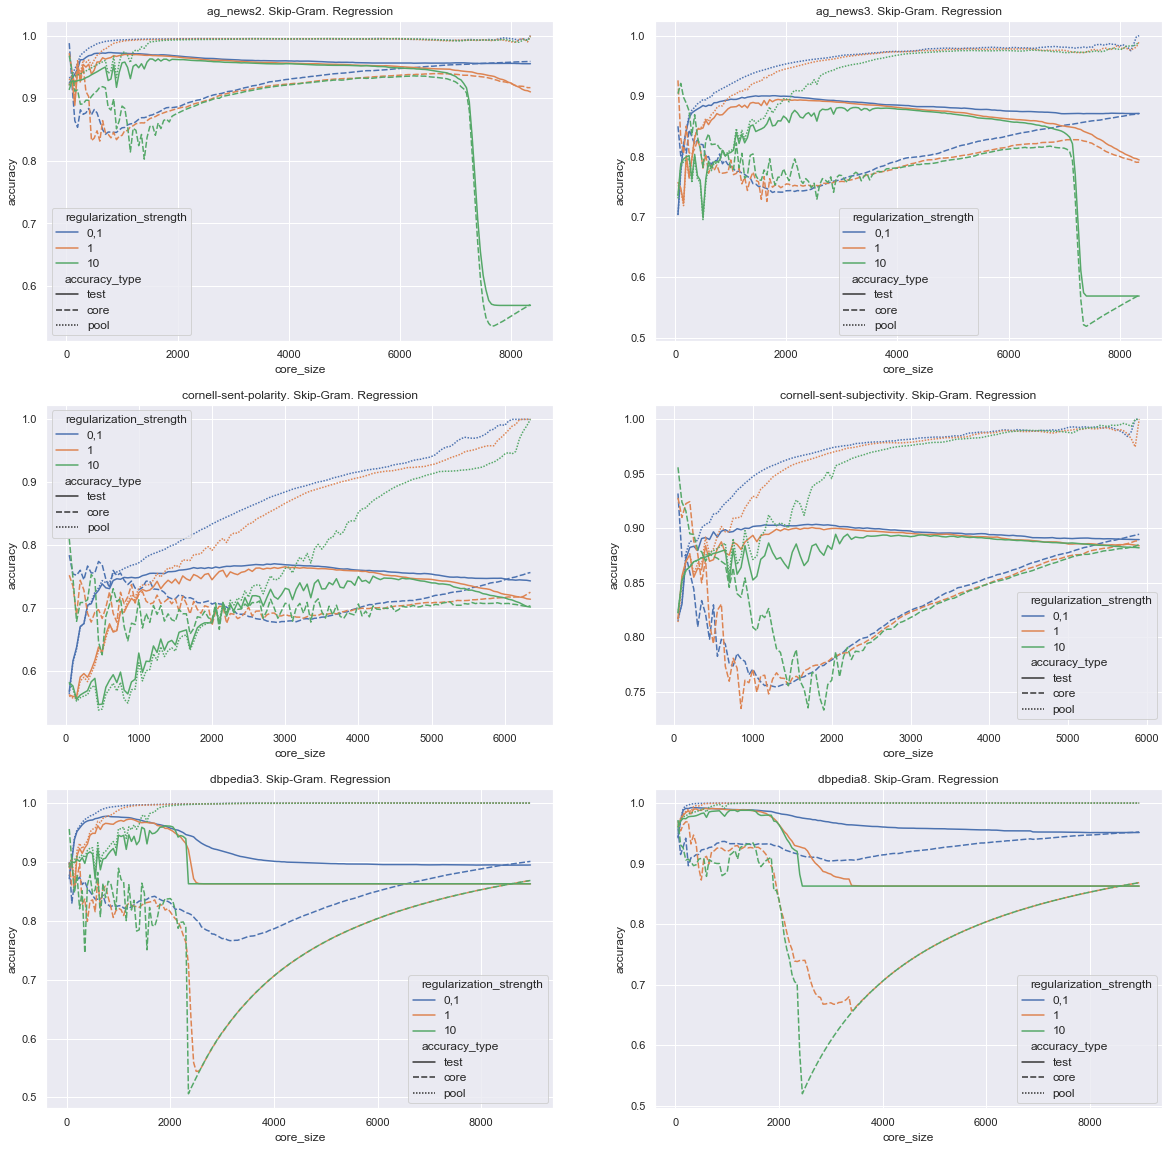

In [19]:
results, datasets, encoders, models = get_data(['word2vec'], ALL_DATASETS, ['Regression', 'Regression0,1', 'Regression10'])
grouped_fst = group_results(results)
fig, ax = plt.subplots(3,2, figsize=(20,20))
sns.set()
gr = grouped_fst
gr['regularization_strength'] = gr['model'].map(lambda x: reg_map(x))
for i, dataset in enumerate(sorted(datasets)):
    df = gr[(gr.dataset == dataset) & (gr.strategy == 'uncertainty sampling')]
    df = df[df.core_size%50==0]
    
    #max_difference = df.test_acc.max() - df.test_acc.iloc[-1]

    current = df[['core_size', 'regularization_strength']]

    current['test'] = df['test_acc']
    current['core'] = df['current_train_acc']
    current['pool'] = df['remaining_train_acc']
    current = current.melt(['core_size', 'regularization_strength'], var_name='accuracy_type',  value_name='accuracy')
    sns_plot = sns.lineplot(x='core_size', y='accuracy', data=current,
                            hue='regularization_strength', style='accuracy_type', hue_order=['0,1', '1', '10'], ax=ax[i//2][i%2])
    sns_plot.set_title('{}. Skip-Gram. Regression'.format(dataset))


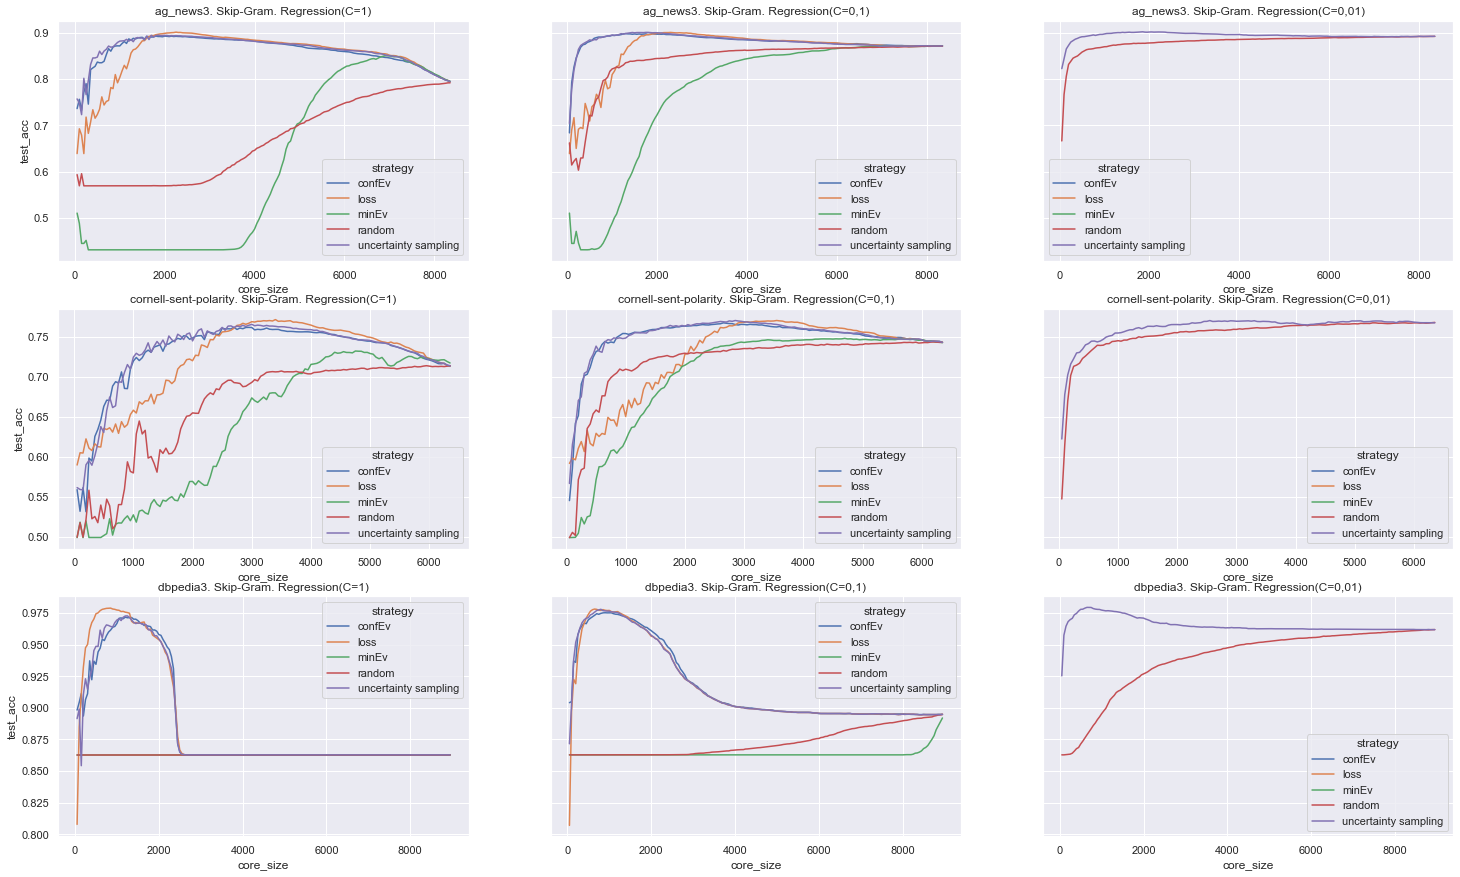

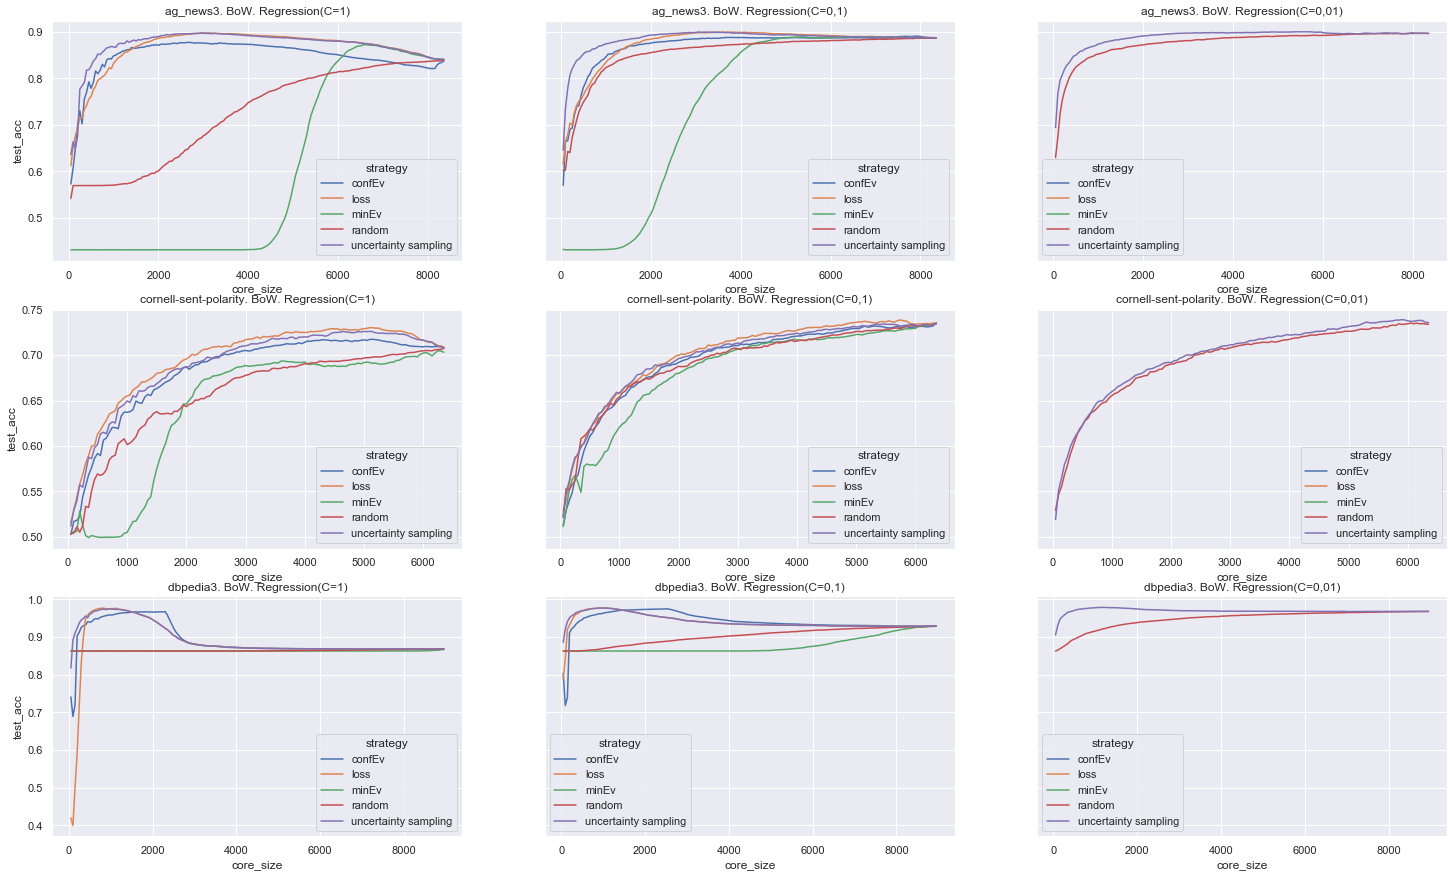

In [12]:
for emb in ['word2vec', 'bow']:
    results, datasets, encoders, models = get_data([emb], ['cornell-sent-polarity', 'ag_news3', 'dbpedia3'], ['Regression', 'Regression10', 'Regression100'])
    grouped_fst = group_results(results)
    fig, ax = plt.subplots(3,3, figsize=(25,15), sharey='row')
    sns.set()
    gr = grouped_fst[grouped_fst.core_size%50 == 0]
    gr['regularization_strength'] = gr['model'].map(lambda x: reg_map(x))
    for i, dataset in enumerate(sorted(datasets)):
        for j, r_s in enumerate(['1', '0,1', '0,01']):
            df = gr[(gr.dataset == dataset) & (gr.regularization_strength == r_s)]

            sns_plot = sns.lineplot(x='core_size', y='test_acc', data=df,
                                    hue='strategy', hue_order=['confEv', 'loss', 'minEv', 'random', 'uncertainty sampling'], ax=ax[i][j])
            sns_plot.set_title('{}. {}. Regression(C={})'.format(dataset, 'Skip-Gram' if emb=='word2vec' else 'BoW', r_s))


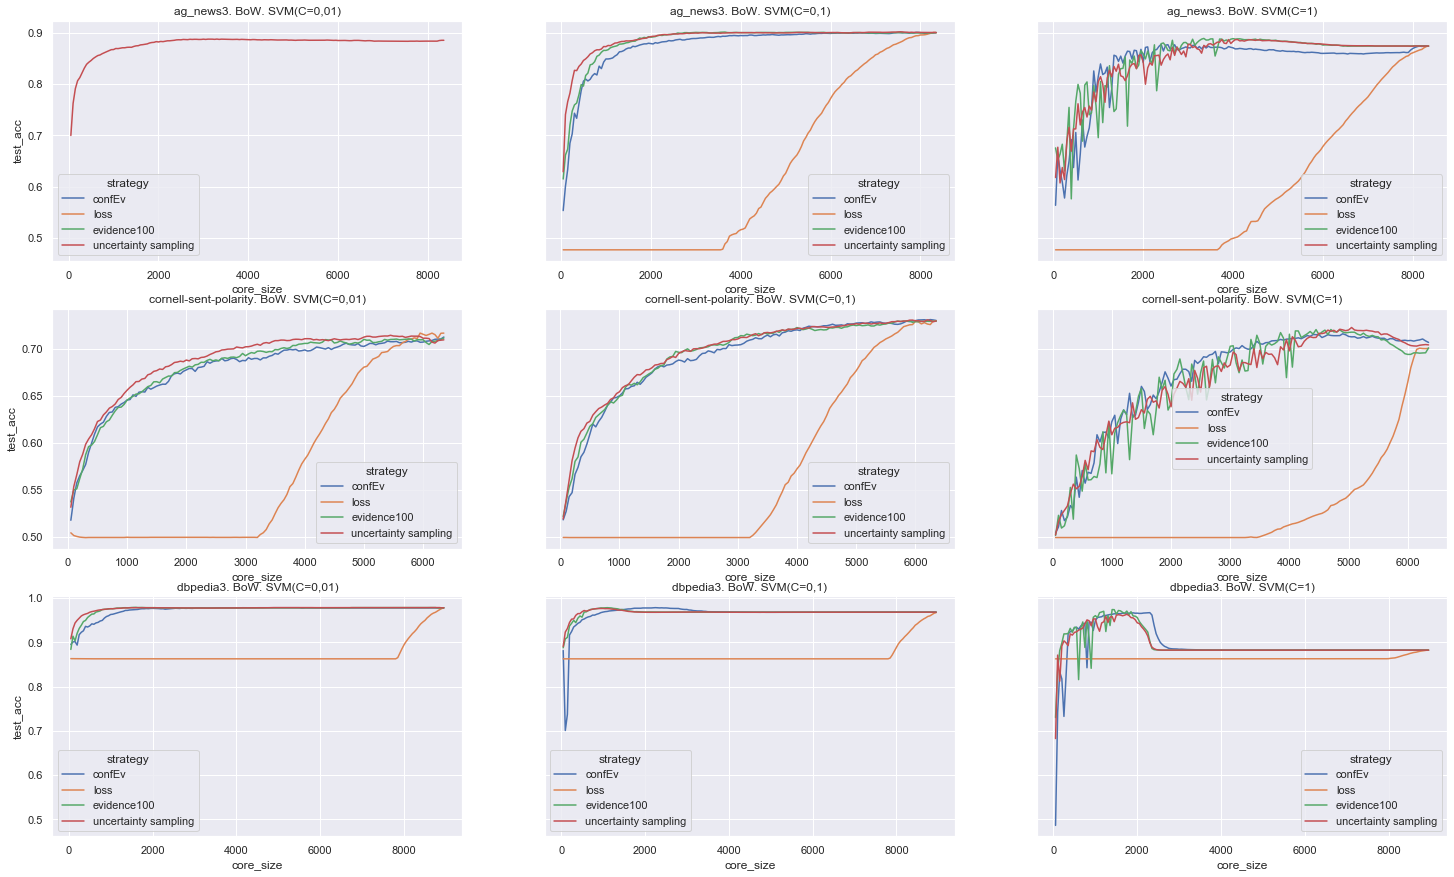

In [10]:
for emb in ['word2vec', 'bow']:
    results, datasets, encoders, models = get_data([emb], ['cornell-sent-polarity', 'ag_news3', 'dbpedia3'], ['svmHinge', 'svmHinge0,1', 'svmHinge0,01'])
    grouped_fst = group_results(results)
    fig, ax = plt.subplots(3,3, figsize=(25,15), sharey='row')
    sns.set()
    gr = grouped_fst[grouped_fst.core_size%50 == 0]
    gr['regularization_strength'] = gr['model'].map(lambda x: reg_map(x))
    for i, dataset in enumerate(sorted(datasets)):
        for j, r_s in enumerate(['1', '10', '100']):
            df = gr[(gr.dataset == dataset) & (gr.regularization_strength == r_s)]

            sns_plot = sns.lineplot(x='core_size', y='test_acc', data=df,
                                    hue='strategy', hue_order=['confEv', 'loss', 'minEv', 'random', 'uncertainty sampling'], ax=ax[i][j])
            sns_plot.set_title('{}. {}. SVM(C={})'.format(dataset, 'Skip-Gram' if emb=='word2vec' else 'BoW', r_s))

In [28]:
results, datasets, encoders, models = get_data(['word2vec'], ['cornell-sent-polarity', 'ag_news3', 'dbpedia3'], ['Regression', 'Regression0,1', 'Regression10'])
grouped_fst = group_results(results)
grouped_fst.head()

core_size strategy                dataset          model   encoding  \
0         10   confEv               ag_news3     Regression  skip-gram   
1         10   confEv               ag_news3  Regression0,1  skip-gram   
2         10   confEv               ag_news3   Regression10  skip-gram   
3         10   confEv  cornell-sent-polarity     Regression  skip-gram   
4         10   confEv  cornell-sent-polarity  Regression0,1  skip-gram   

   model_type regularization_strength  test_acc  ask_id  current_train_acc  \
0  Regression                       1  0.517929    -1.0               0.71   
1  Regression                      10  0.511982    -1.0               0.69   
2  Regression                     0,1  0.517911    -1.0               0.71   
3  Regression                       1  0.518312    -1.0               0.74   
4  Regression                      10  0.514560    -1.0               0.74   

   remaining_train_acc  support_vectors    w_norm  total_loss  avg_loss  \
0             0.516150              0.0  0.368423    6.163799      -1.0   
1             0.510679              0.0  0.365284    6.169629      -1.0   
2             0.516186              0.0  0.683922    6.106143      -1.0   
3             0.517520              0.0  0.234193    6.392549      -1.0   
4             0.515986              0.0  0.231826    6.397008      -1.0   

     test_loss  queried_loss  certainty  
0  4356.076365          -1.0   0.659551  
1  4357.173229          -1.0   0.659950  
2  4345.102593          -1.0   0.655524  
3  3198.063608          -1.0   0.639710  
4  3198.217747          -1.0   0.639969

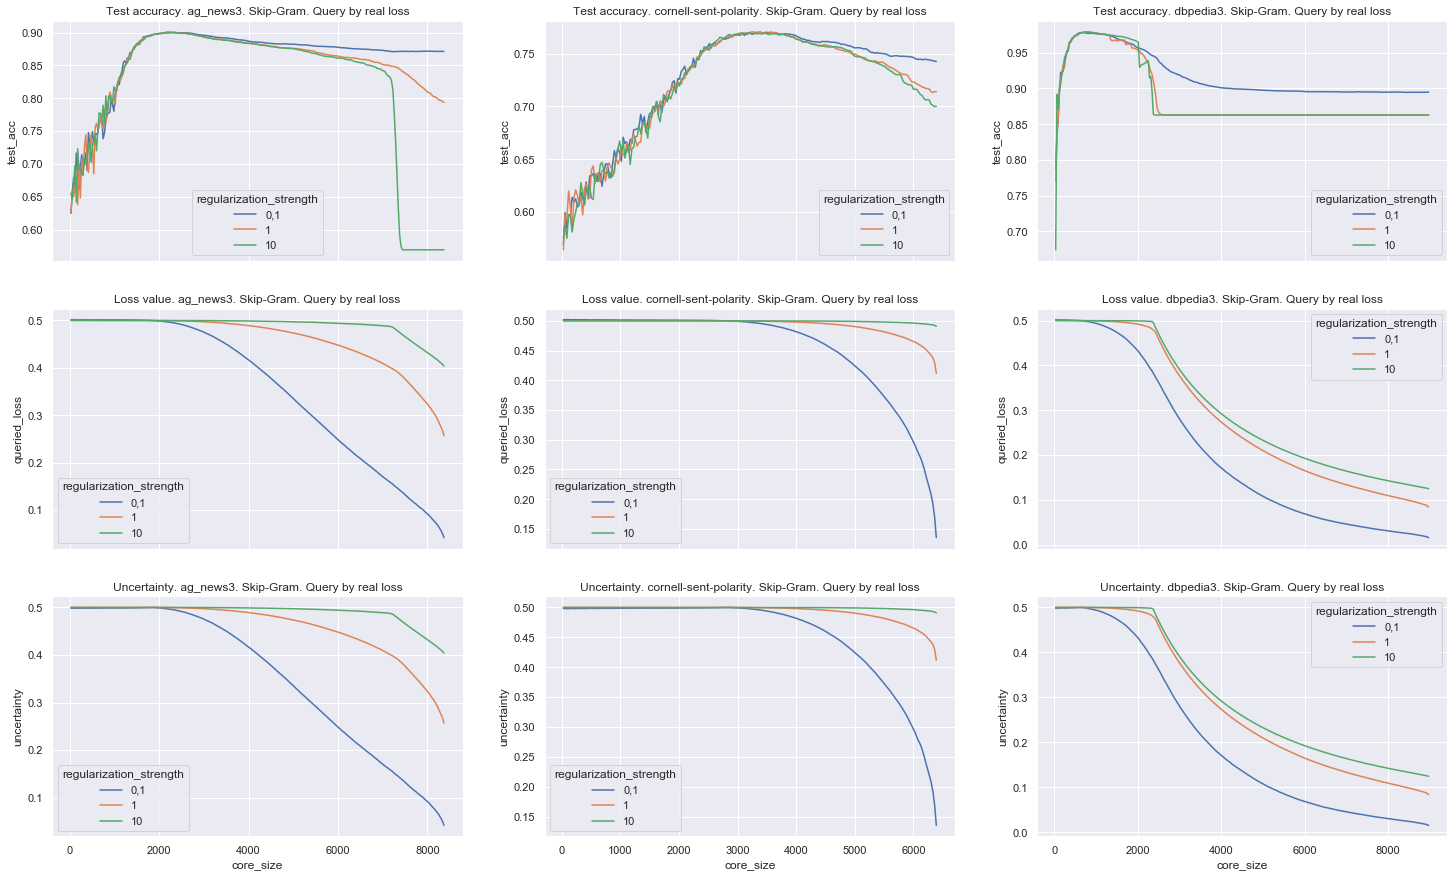

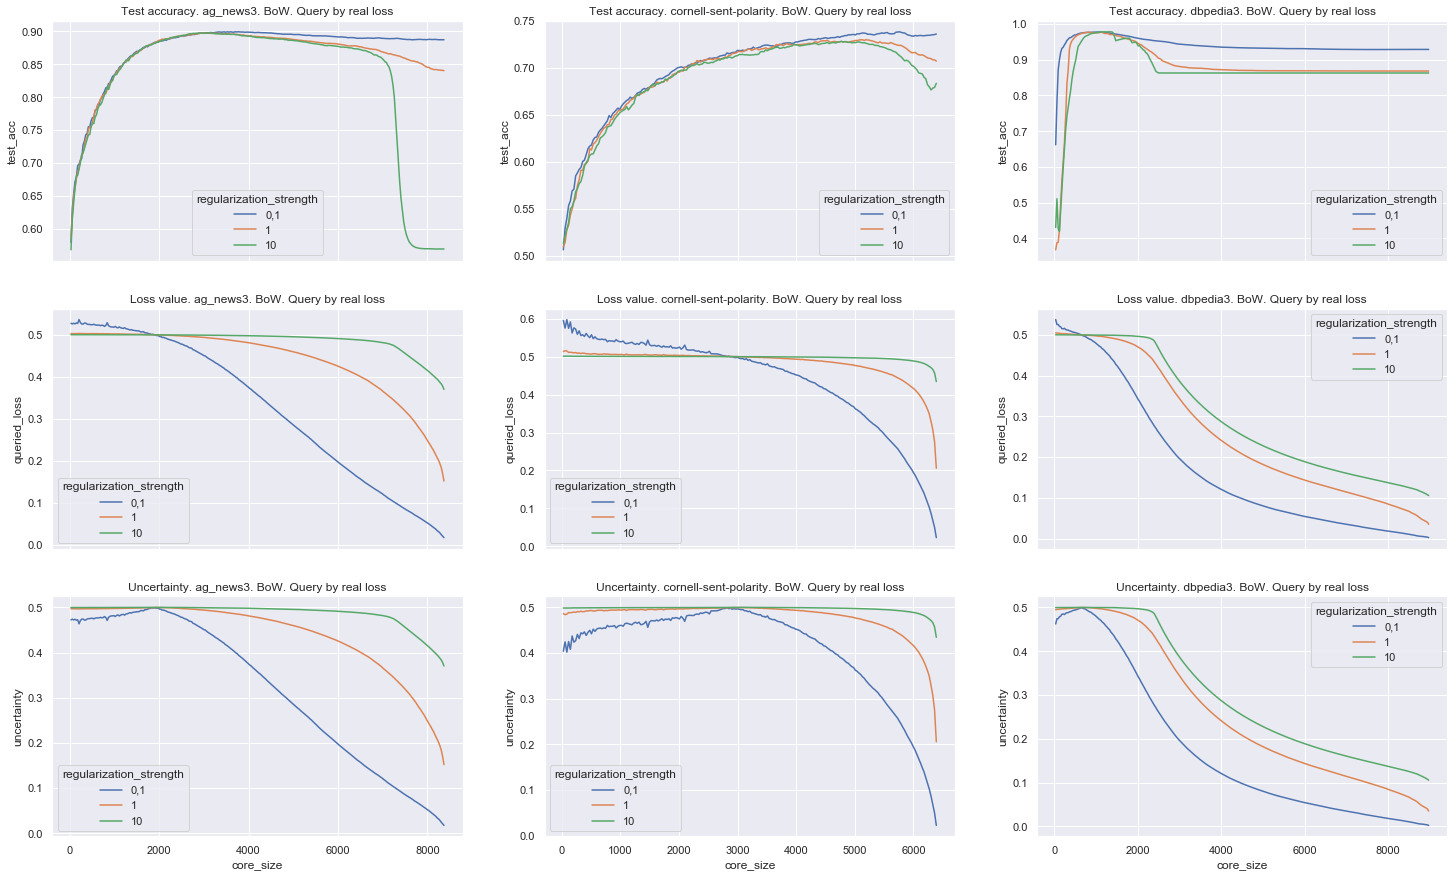

In [42]:
for emb in ['word2vec', 'bow']:
    results, datasets, encoders, models = get_data([emb], ['cornell-sent-polarity', 'ag_news3', 'dbpedia3'], ['Regression', 'Regression0,1', 'Regression10'])
    grouped_fst = group_results(results)
    fig, ax = plt.subplots(3,3, figsize=(25,15 ), sharex='col')
    sns.set()
    gr = grouped_fst[(grouped_fst.core_size%30 == 0) & (grouped_fst.strategy == 'loss')]
    gr['regularization_strength'] = gr['model'].map(lambda x: reg_map(x))
    for i, dataset in enumerate(sorted(datasets)):
        df = gr[(gr.dataset == dataset)]
        sns_plot = sns.lineplot(x='core_size', y='test_acc', data=df,
                                    hue='regularization_strength', hue_order=['0,1', '1', '10'], ax=ax[0][i])
        sns_plot.set_title('Test accuracy. {}. {}. Query by real loss'.format(dataset, 'Skip-Gram' if emb=='word2vec' else 'BoW', r_s))

        sns_plot = sns.lineplot(x='core_size', y='queried_loss', data=df,
                                    hue='regularization_strength', hue_order=['0,1', '1', '10'], ax=ax[1][i])
        sns_plot.set_title('Loss value. {}. {}. Query by real loss'.format(dataset, 'Skip-Gram' if emb=='word2vec' else 'BoW', r_s))

        df['uncertainty'] = 1 - df['certainty']
        sns_plot = sns.lineplot(x='core_size', y='uncertainty', data=df,
                                    hue='regularization_strength', hue_order=['0,1', '1', '10'], ax=ax[2][i])
        sns_plot.set_title('Uncertainty. {}. {}. Query by real loss'.format(dataset, 'Skip-Gram' if emb=='word2vec' else 'BoW', r_s))
    fig.savefig(emb+'loss strategy.png')


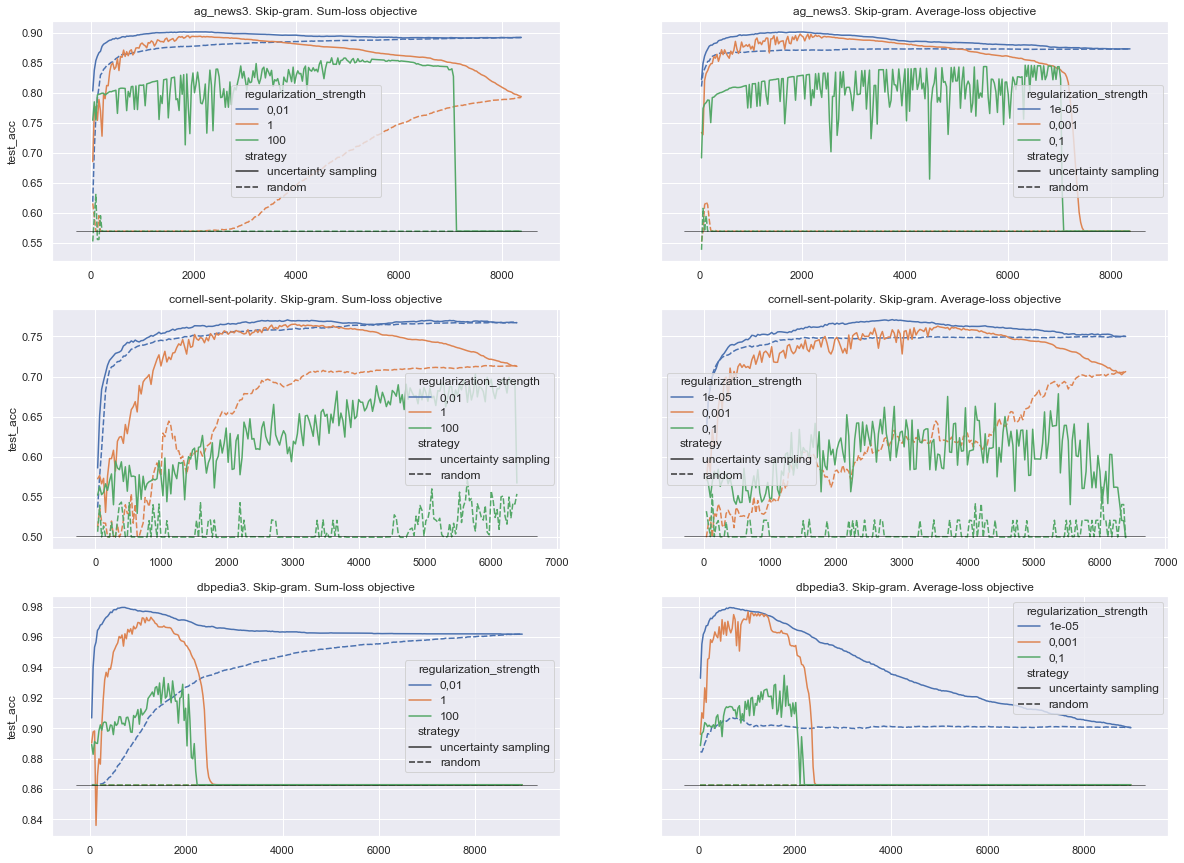

In [274]:

current = results[results.core_size%30 == 6]
fig, axs = plt.subplots(ncols=2, nrows=len(datasets), figsize=(20,15), sharey='row')
sns.set()
for i, ds in enumerate(datasets):
    df = current[(current.model_type == 'Regression') & (current.dataset == ds)]
    sns_plot = sns.lineplot(x='core_size', y='test_acc', 
                            hue='regularization_strength',hue_order=['0,01', '1', '100'],
                            data=df, style='strategy', style_order=[ 'uncertainty sampling', 'random'],
                            ax=axs[i][0], ci=None)
    
    baseline = get_baseline(ds)
    sns_plot.plot([-300, max(df['core_size'])+300], [baseline, baseline], color='black', linewidth=0.5)
    sns_plot.set_title(ds + '. Skip-gram. Sum-loss objective')
    sns_plot.set_xlabel('')    
    
    df = current[(current.model_type == 'RegressionStable') & (current.dataset == ds)]
    sns_plot = sns.lineplot(x='core_size', y='test_acc', 
                            hue='regularization_strength', hue_order=['1e-05', '0,001', '0,1'],
                            data=df, style='strategy', style_order=[ 'uncertainty sampling', 'random'],
                            ax=axs[i][1], ci=None)
    
    baseline = get_baseline(ds)
    sns_plot.plot([-300, max(df['core_size'])+300], [baseline, baseline], color='black', linewidth=0.5)
    sns_plot.set_title(ds + '. Skip-gram. Average-loss objective')
    sns_plot.set_xlabel('')

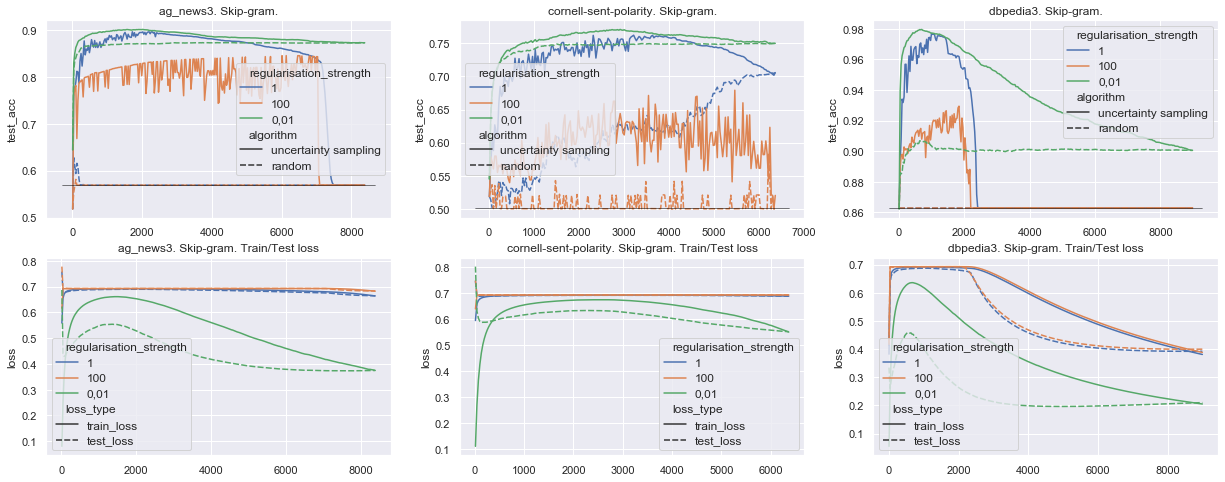

In [179]:

test_sizes = [5600, 4265, 6000]
current = results[results.core_size%30 == 10]
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(21,8))
sns.set()
for i, ds in enumerate(datasets):
    df = current[(current.model_type == 'RegressionStable') & (current.dataset == ds)]
    sns_plot = sns.lineplot(x='core_size', y='test_acc', 
                            hue='regularization_strength',#hue_order=['fasttext', 'bow'], 
                            data=df, style='strategy', style_order=[ 'uncertainty sampling', 'random'],
                            ax=axs[0][i], ci=None)
    
    baseline = get_baseline(ds)
    sns_plot.plot([-300, max(df['core_size'])+300], [baseline, baseline], color='black', linewidth=0.5)
    sns_plot.set_title(ds + '. Skip-gram.')
    sns_plot.set_xlabel('')    
    
    df = df[df.strategy != 'random']
    df['train_loss'] = df.total_loss / df.core_size
    df['test_loss'] = df.test_loss / test_sizes[i]
    df = df.melt(id_vars=['core_size', 'regularization_strength'], value_vars=['train_loss', 'test_loss'],  value_name='loss', var_name='loss_type')
    sns_plot = sns.lineplot(x='core_size', y='loss', 
                            hue='regularization_strength',#hue_order=['fasttext', 'bow'], 
                            data=df, style='loss_type',
                            ax=axs[1][i], ci=None)
    
    #sns_plot.plot([-300, max(df['core_size'])+300], [baseline, baseline], color='black', linewidth=0.5)
    sns_plot.set_title(ds + '. Skip-gram. Train/Test loss')
    sns_plot.set_xlabel('')

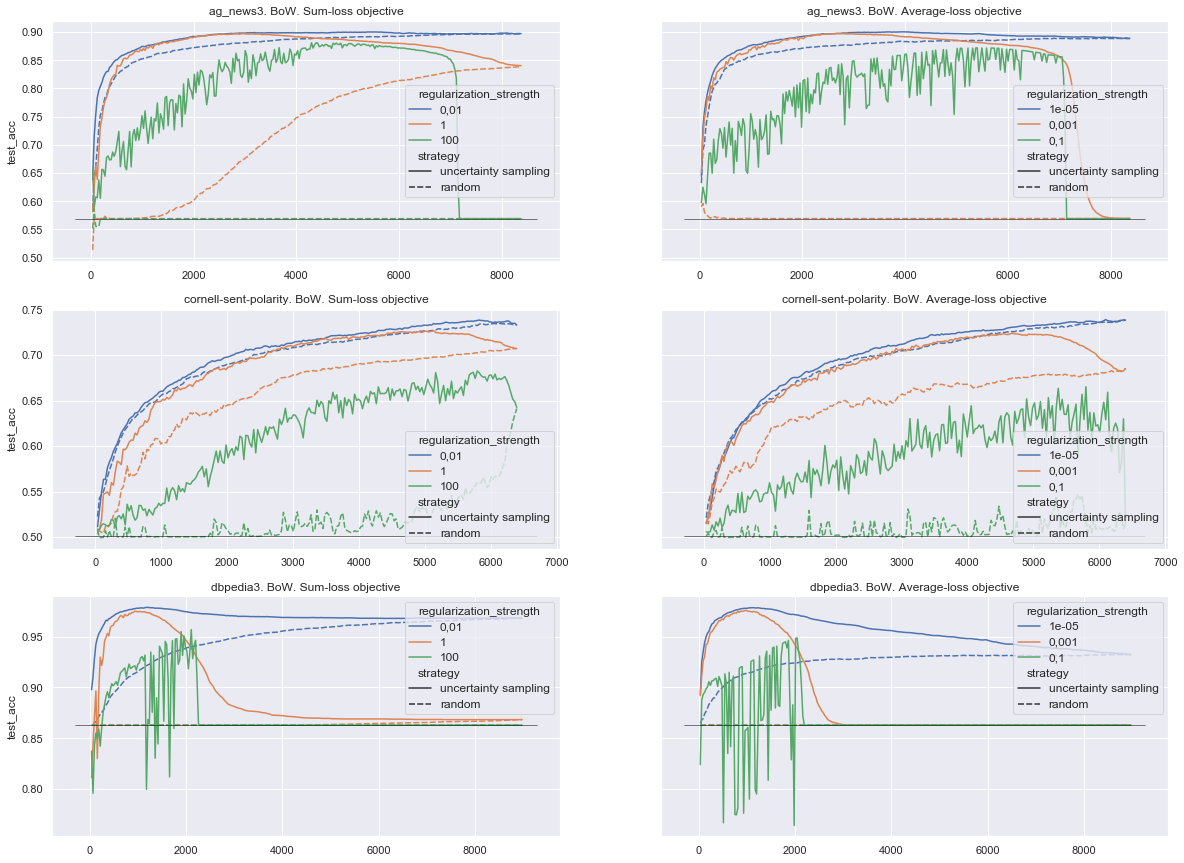

In [279]:
results, datasets, encoders, models = get_data(['bow'], ['cornell-sent-polarity', 'ag_news3', 'dbpedia3'], ['RegressionStable0,01', 'RegressionStable100','RegressionStable','Regression','Regression0,01','Regression100'])
grouped_fst = group_results(results)

current = results[results.core_size%30 == 6]
fig, axs = plt.subplots(ncols=2, nrows=len(datasets), figsize=(20,15), sharey='row')
sns.set()
for i, ds in enumerate(datasets):
    df = current[(current.model_type == 'Regression') & (current.dataset == ds)]
    sns_plot = sns.lineplot(x='core_size', y='test_acc', 
                            hue='regularization_strength',hue_order=['0,01', '1', '100'],
                            data=df, style='strategy', style_order=[ 'uncertainty sampling', 'random'],
                            ax=axs[i][0], ci=None)
    
    baseline = get_baseline(ds)
    sns_plot.plot([-300, max(df['core_size'])+300], [baseline, baseline], color='black', linewidth=0.5)
    sns_plot.set_title(ds + '. BoW. Sum-loss objective')
    sns_plot.set_xlabel('')    
    
    df = current[(current.model_type == 'RegressionStable') & (current.dataset == ds)]
    sns_plot = sns.lineplot(x='core_size', y='test_acc', 
                            hue='regularization_strength', hue_order=['1e-05', '0,001', '0,1'],
                            data=df, style='strategy', style_order=[ 'uncertainty sampling', 'random'],
                            ax=axs[i][1], ci=None)
    
    baseline = get_baseline(ds)
    sns_plot.plot([-300, max(df['core_size'])+300], [baseline, baseline], color='black', linewidth=0.5)
    sns_plot.set_title(ds + '. BoW. Average-loss objective')
    sns_plot.set_xlabel('')

In [117]:
%%time
from active_learning import LogisticRegressionStable
from data_loader import load_train_test
encoder = Word2VecEncoder()
for ds in datasets:
    _, X_train, X_test, y_train, y_test = load_train_test(ds, encoder, -1)
    print(y_test.shape)

(5600,)
(4265,)
(6000,)
Wall time: 11.2 s


In [60]:
%%time
from data_loader import load_train_test
encoder = Word2VecEncoder()
_, X_train, X_test, y_train, y_test = load_train_test('dbpedia3', encoder, -1)

Wall time: 4.36 s


In [107]:

from libact.base.dataset import Dataset
from libact.models import LogisticRegression
model = LogisticRegression(C=10,solver = 'lbfgs', max_iter=10000, class_weight='balanced')
model.model.fit(X_train,y_train)
model.model.score(X_test, y_test)

0.9045

In [74]:
y_test.shape, y_test.sum()

((6000,), 823)

In [108]:
np.bincount(y_train)

array([7823, 1177], dtype=int64)

In [110]:
model.model.class_weight

'balanced'

In [63]:
results, datasets, encoders, models = get_data(['word2vec'], ['dbpedia3'], ['Regression10'])
grouped_fst = group_results(results)

In [64]:
print(grouped_fst[grouped_fst.strategy == 'uncertainty sampling']['test_acc'].max())
grouped_fst[grouped_fst.strategy == 'uncertainty sampling'].tail(1)

0.97815


core_size              strategy   dataset         model   encoding  \
71919       8999  uncertainty sampling  dbpedia3  Regression10  skip-gram   

       model_type regularization_strength  test_acc  ask_id  \
71919  Regression                     0,1  0.894833  4246.5   

       current_train_acc  remaining_train_acc  support_vectors       w_norm  \
71919           0.901433                  1.0              0.0  4806.106082   

        total_loss  avg_loss   test_loss  certainty  
71919  1897.239158      -1.0  1298.81051   0.987651

In [102]:
def upsample(X,y, k=2):
    idx = np.random.RandomState(1).choice(y.nonzero()[0], size=int(sum(y)*(k-1)))
    return np.vstack([X,X[idx,:]]), np.hstack([y, y[idx]])

def downsample(X,y,k=0.5):
    idx = np.random.RandomState(1).choice(np.logical_not(y).nonzero()[0], size=int((len(y)-sum(y))*k))
    return np.vstack([X[y.nonzero()[0],:],X[idx, :]]), np.array([1]*sum(y) + [0]*len(idx))

    

In [96]:
for k in [1.5, 2,4,8]:
    X, y = upsample(X_train, y_train, k)
    model.model.fit(X,y)
    print(model.model.score(X_test, y_test))

0.9305
0.948
0.9485
0.9051666666666667


In [105]:
for k in [0.25, 0.5, 0.75]:
    X, y = downsample(X_train, y_train, k)
    model.model.fit(X,y)
    print(model.model.score(X_test, y_test))

0.936
0.9281666666666667
0.9083333333333333


In [101]:
X_train.shape

(9000, 300)

TypeError: fit() got an unexpected keyword argument 'class_weight'

In [51]:
grouped_fst[grouped_fst.strategy == 'uncertainty sampling'].tail()

core_size              strategy                dataset         model  \
51063       6392  uncertainty sampling  cornell-sent-polarity  Regression10   
51071       6393  uncertainty sampling  cornell-sent-polarity  Regression10   
51079       6394  uncertainty sampling  cornell-sent-polarity  Regression10   
51087       6395  uncertainty sampling  cornell-sent-polarity  Regression10   
51095       6396  uncertainty sampling  cornell-sent-polarity  Regression10   

        encoding  model_type regularization_strength  test_acc  ask_id  \
51063  skip-gram  Regression                     0,1  0.742368  2369.8   
51071  skip-gram  Regression                     0,1  0.742321   779.4   
51079  skip-gram  Regression                     0,1  0.742603  4008.3   
51087  skip-gram  Regression                     0,1  0.742345  4752.4   
51095  skip-gram  Regression                     0,1  0.742532  4036.4   

       current_train_acc  remaining_train_acc  support_vectors       w_norm  \
51063           0.757416                  1.0              0.0  2781.068235   
51071           0.757407                  1.0              0.0  2784.726581   
51079           0.757507                  1.0              0.0  2782.049177   
51087           0.757342                  1.0              0.0  2786.683621   
51095           0.757348                  1.0              0.0  2788.000582   

        total_loss  avg_loss    test_loss  certainty  
51063  3656.695308      -1.0  2449.486995   0.868207  
51071  3656.470323      -1.0  2449.235894   0.873089  
51079  3656.876908      -1.0  2449.343427   0.875780  
51087  3656.542253      -1.0  2449.094931   0.882361  
51095  3656.538640      -1.0  2448.931238   0.887443

In [156]:
%%time
from libact.base.dataset import Dataset
from libact.query_strategies import UncertaintySampling
from libact.models import LogisticRegression
model = LogisticRegression(C=10,solver = 'lbfgs', max_iter=10000)
res = []
test_ds = Dataset(X_test, y_test)
for core_size in [100, 500, 1000]:
    for restart in range(10):
        print(core_size, restart)
        random = np.random.RandomState(core_size + restart)

        idx = random.choice(len(y_train), core_size, False)
        while len(set(y_train[idx])) == 1:
            idx = random.choice(len(y_train), core_size, False)
        round_labels = np.array([None] * len(y_train))
        round_labels[idx] = y_train[idx]

        train_ds = Dataset(X_train, round_labels)
        strategy = UncertaintySampling(train_ds, model=model)
        prev_ask_id = -1
        for i in range(y_train.shape[0] - core_size):
            ask_id = strategy.make_query()
            current_model = strategy.model

            idx, remaining_train_X = train_ds.get_unlabeled_entries()
            remaining_train = Dataset(remaining_train_X, y_train[idx])
            remaining_train_score = current_model.score(remaining_train)
            test_score = current_model.score(test_ds)
            core_score = current_model.score(train_ds)
            res.append([core_size, restart, i+core_size, test_score, core_score, remaining_train_score])
            train_ds.update(ask_id, y_train[ask_id])

100 0
100 1
100 2
100 3
100 4
100 5
100 6
100 7
100 8
100 9
500 0
500 1
500 2
500 3
500 4
500 5
500 6
500 7
500 8
500 9
1000 0
1000 1
1000 2
1000 3
1000 4
1000 5
1000 6
1000 7
1000 8
1000 9
Wall time: 5h 10min 53s


In [216]:
results, datasets, encoders, models = get_data(['word2vec'], ['cornell-sent-polarity'], ['Regression10'])
results = results[results.strategy != 'random']
results['pool_acc'] = results.remaining_train_acc
results['core_acc'] = results.current_train_acc
results = results[['restart', 'core_size', 'test_acc', 'core_acc', 'pool_acc']]
results['start_size'] = 10
results.head()

restart  core_size  test_acc  core_acc  pool_acc  start_size
0       0         10  0.499179  0.600000  0.500391          10
1       0         11  0.499179  0.545455  0.500470          10
2       0         12  0.499179  0.583333  0.500392          10
3       0         13  0.499179  0.538462  0.500470          10
4       0         14  0.562485  0.785714  0.568071          10

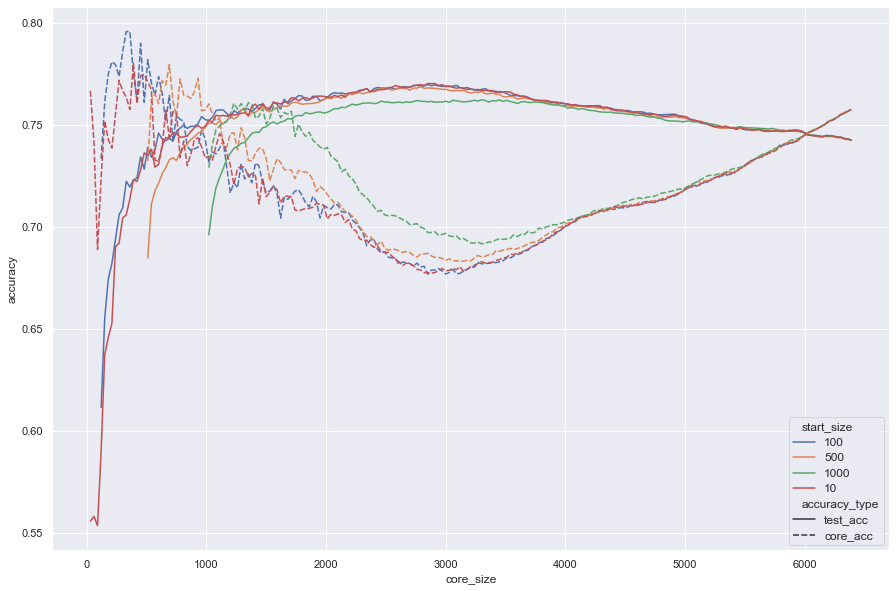

In [218]:
plt.figure(figsize=(15,10))
df = pd.DataFrame(res, columns=['start_size','restart', 'core_size', 'test_acc', 'core_acc', 'pool_acc'])
df = df.append(results)
df = df[df.core_size%30 == 0]
df['start_size'] = df.start_size.astype(str)
df = df.melt(['start_size','core_size', 'restart'], var_name='accuracy_type',  value_name='accuracy')
sns.lineplot(x='core_size', y='accuracy', 
                            hue='start_size', style='accuracy_type', style_order = ['test_acc', 'core_acc', 'pool_acc'],
                            data=df, ci=None)

In [220]:
results, datasets, encoders, models = get_data(['transformer'], ['cornell-sent-polarity', 'ag_news3', 'dbpedia3'])
results.head(1)

core_size  test_acc  ask_id  current_train_acc  remaining_train_acc  \
0         10  0.499179      -1                0.7             0.500235   

   support_vectors    w_norm  total_loss  avg_loss algorithm restart  \
0                0  0.651981    6.049894        -1    random       9   

                 dataset     encoding         model    test_loss  certainty  \
0  cornell-sent-polarity  transformer  Regression10  3328.490911   0.701427   

   model_type regularisation_strength  
0  Regression                     0,1

In [222]:
datasets

['ag_news3', 'cornell-sent-polarity', 'dbpedia3']

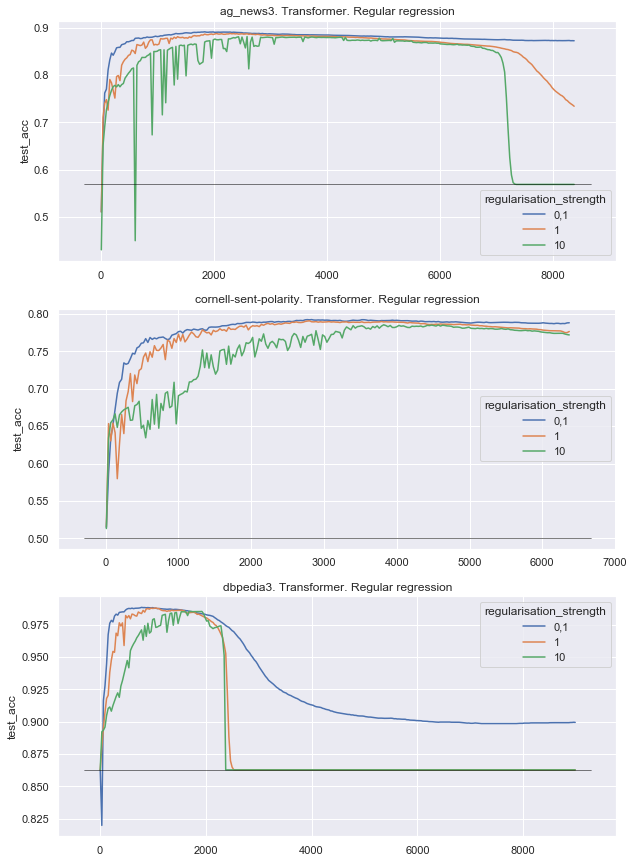

In [223]:
#results, datasets, encoders, models = get_data(['transformer'], ['cornell-sent-polarity', 'ag_news3', 'dbpedia3'])
#grouped_fst = group_results(results)
current = results[results.core_size%30 == 10]
fig, axs = plt.subplots(ncols=1, nrows=len(datasets), figsize=(10,15))
sns.set()
for i, ds in enumerate(datasets):
    df = current[(current.dataset == ds)]
    sns_plot = sns.lineplot(x='core_size', y='test_acc', 
                            hue='regularization_strength',hue_order=['0,1', '1', '10'],
                            data=df, 
                            ax=axs[i], ci=None)
    
    baseline = get_baseline(ds)
    sns_plot.plot([-300, max(df['core_size'])+300], [baseline, baseline], color='black', linewidth=0.5)
    sns_plot.set_title(ds + '. Transformer. Regular regression')
    sns_plot.set_xlabel('')    

In [198]:
results[results.strategy != 'random'].groupby('train_size').mean().test_acc.max(), results[results.strategy != 'random'].groupby('train_size').mean().test_acc.values[-1]

(0.7945520998551823, 0.7885431098795695)

In [112]:
data = []
for restart in range(10):
    random = np.random.RandomState(restart)
    idx = random.choice(len(y_train), 10, False)
    while len(set(y_train[idx])) == 1:
        idx = random.choice(len(y_train), 10, False)
    idx = list(idx)
    core_size = 10
    history = results[(results.model == 'RegressionStable0,01') & (results.restart == str(restart)) & (results.strategy != 'random')& (results.dataset == datasets[1])].ask_id.values.astype('int')
    for i, ask_id in enumerate(history):
        if not ask_id == -1:
            #train_ds.update(ask_id, lbl)
            idx.append(ask_id)
            core_size += 1
        if core_size%10000 == 5395:
            core_y = y_train[idx]
            core_X = X_train[idx, :]
            train_ds = Dataset(core_X, core_y)
            learner.train(train_ds)
            data.append([core_size] + [learner.score(Dataset(X_test, y_test))])
#train_ds = Dataset(core_X, core_y)
#learner.train(train_ds)
#data.append([core_size] + [learner.score(Dataset(X_test, y_test))])
#data.append([6397, learner])
data

[[5395, 0.5425556858147714],
 [5395, 0.5062133645955451],
 [5395, 0.5430246189917937],
 [5395, 0.5413833528722157],
 [5395, 0.5097303634232122],
 [5395, 0.5090269636576787],
 [5395, 0.5432590855803048],
 [5395, 0.5432590855803048],
 [5395, 0.5432590855803048],
 [5395, 0.500820633059789]]

In [112]:
%%time
from sklearn.linear_model import LogisticRegression
from data_loader import load_train_test
dataset = 'cornell-sent-subjectivity'
data = []
results, datasets, encoders, models = get_data(['bow'], [dataset], ['Regression', 'Regression0,1', 'Regression10'])

results = results[(results.strategy == 'uncertainty sampling')]

encoder = BoWExtractor()
_, X_train, X_test, y_train, y_test = load_train_test(dataset, encoder, -1)
learners = [LogisticRegression(solver='lbfgs', C=x) for x in [1,0.1, 10]]
for model in models:
    for restart in range(10):
        random = np.random.RandomState(restart)
        idx = random.choice(len(y_train), 10, False)
        while len(set(y_train[idx])) == 1:
            idx = random.choice(len(y_train), 10, False)
        core_y = y_train[idx]
        core_X = X_train[idx, :]
        core_size = 10
        
        history = results[(results.model == model) & (results.restart == str(restart))].ask_id.values.astype('int')
        for i, ask_id in enumerate(history):
            if not ask_id == -1:
                core_y = np.append(core_y, y_train[ask_id])
                core_X = sparse.vstack([core_X, X_train[ask_id, :]])
                core_size += 1
            for l in learners:
                l.fit(core_X, core_y)
            data.append([restart, core_size] + [l.score(X_test, y_test) for l in learners] + [model])
            
            if core_size%1000 == 0:
                print(data[-1])
        
        
df = pd.DataFrame(columns=['restart', 'core_size', 'Regression', 'Regression0,1', 'Regression10', 'query_model'], data=data)      
df.head(2)
        

[0, 1000, 0.8248359414437153, 0.552246340232206, 0.831650681474003, 'Regression']
[0, 2000, 0.8584048460373549, 0.8281171125694093, 0.8644623927309439, 'Regression']
[0, 3000, 0.8626956082786471, 0.7662796567390207, 0.8748107016658253, 'Regression']
[0, 4000, 0.8515901060070671, 0.7001514386673398, 0.8679959616355376, 'Regression']
[0, 5000, 0.8220595658758203, 0.6019687026754165, 0.8644623927309439, 'Regression']
[1, 1000, 0.820545179202423, 0.568904593639576, 0.8281171125694093, 'Regression']
[1, 2000, 0.8566380615850581, 0.8346794548207975, 0.8566380615850581, 'Regression']
[1, 3000, 0.8634528016153458, 0.8361938414941948, 0.8697627460878344, 'Regression']
[1, 4000, 0.8493185259969712, 0.715042907622413, 0.8674911660777385, 'Regression']
[1, 5000, 0.820545179202423, 0.6085310449268047, 0.8647147905098436, 'Regression']
[2, 1000, 0.8334174659262998, 0.6895507319535588, 0.8341746592629985, 'Regression']
[2, 2000, 0.8568904593639576, 0.8298838970217062, 0.8599192327107521, 'Regression'

restart  core_size  Regression  Regression0,1  Regression10 query_model
0        0         10    0.517415       0.517668      0.512620  Regression
1        0         11    0.504038       0.504038      0.517668  Regression

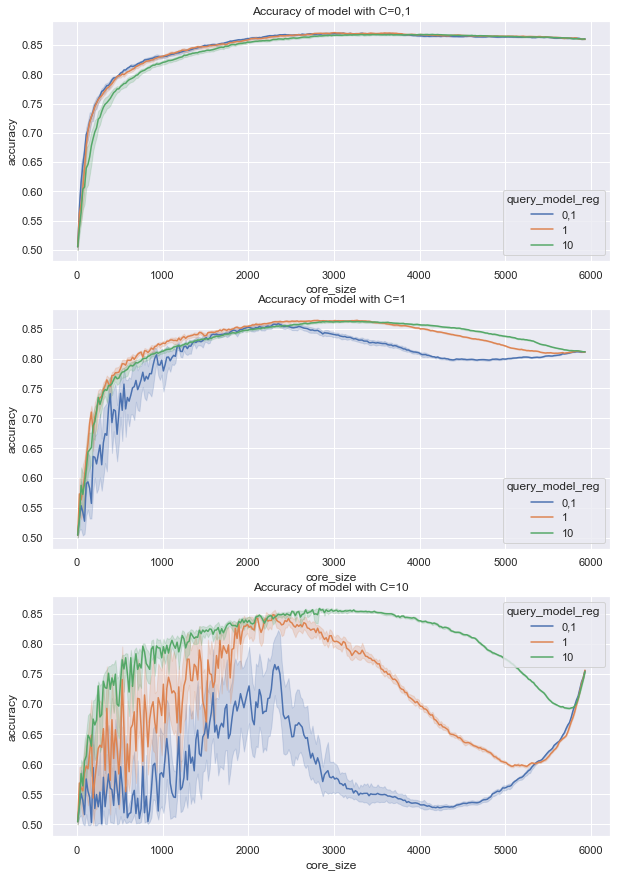

In [124]:
current = df[df.core_size%20 == 10]
fig, ax = plt.subplots(3,1, figsize=(10,15))
#current = current[current.query_model == 'Regression']
current = current.melt(['core_size', 'restart', 'query_model'], var_name='model',  value_name='accuracy')
current['regularization_strength'] = current['model'].map(lambda x: reg_map(x))
current['query_model_reg'] = current['query_model'].map(lambda x: reg_map(x))
for i, query_reg in enumerate(['0,1', '1', '10']):
    p = sns.lineplot(x='core_size', y='accuracy', hue='query_model_reg', hue_order=['0,1', '1', '10'], ax=ax[i], data=current[current.regularization_strength == query_reg])
    p.set_title('Accuracy of LR with C=' + str(query_reg))

In [127]:
%%time
from sklearn.linear_model import LogisticRegression
from data_loader import load_train_test
dataset = 'ag_news2'
data = []
results, datasets, encoders, models = get_data(['bow'], [dataset], ['Regression', 'Regression0,1', 'Regression10'])

results = results[(results.strategy == 'uncertainty sampling')]

encoder = BoWExtractor()
_, X_train, X_test, y_train, y_test = load_train_test(dataset, encoder, -1)
learners = [LogisticRegression(solver='lbfgs', C=x) for x in [1,0.1, 10]]
for model in models:
    for restart in range(10):
        print(model, restart)
        random = np.random.RandomState(restart)
        idx = random.choice(len(y_train), 10, False)
        while len(set(y_train[idx])) == 1:
            idx = random.choice(len(y_train), 10, False)
        core_y = y_train[idx]
        core_X = X_train[idx, :]
        core_size = 10
        
        history = results[(results.model == model) & (results.restart == str(restart))].ask_id.values.astype('int')
        for i, ask_id in enumerate(history):
            if not ask_id == -1:
                core_y = np.append(core_y, y_train[ask_id])
                core_X = sparse.vstack([core_X, X_train[ask_id, :]])
                core_size += 1
            if core_size%20 == 10:
                for l in learners:
                    l.fit(core_X, core_y)
                data.append([restart, core_size] + [l.score(X_test, y_test) for l in learners] + [model])
        
        
        
df = pd.DataFrame(columns=['restart', 'core_size', 'Regression', 'Regression0,1', 'Regression10', 'query_model'], data=data)      
df.head(2)
        

Regression 0
Regression 1
Regression 2
Regression 3
Regression 4
Regression 5
Regression 6
Regression 7
Regression 8
Regression 9
Regression0,1 0
Regression0,1 1
Regression0,1 2
Regression0,1 3
Regression0,1 4
Regression0,1 5
Regression0,1 6
Regression0,1 7
Regression0,1 8
Regression0,1 9
Regression10 0
Regression10 1
Regression10 2
Regression10 3
Regression10 4
Regression10 5
Regression10 6
Regression10 7
Regression10 8
Regression10 9
Wall time: 1h 14min 30s


restart  core_size  Regression  Regression0,1  Regression10 query_model
0        0         10    0.430893       0.430893      0.430893  Regression
1        0         30    0.471250       0.470000      0.478929  Regression

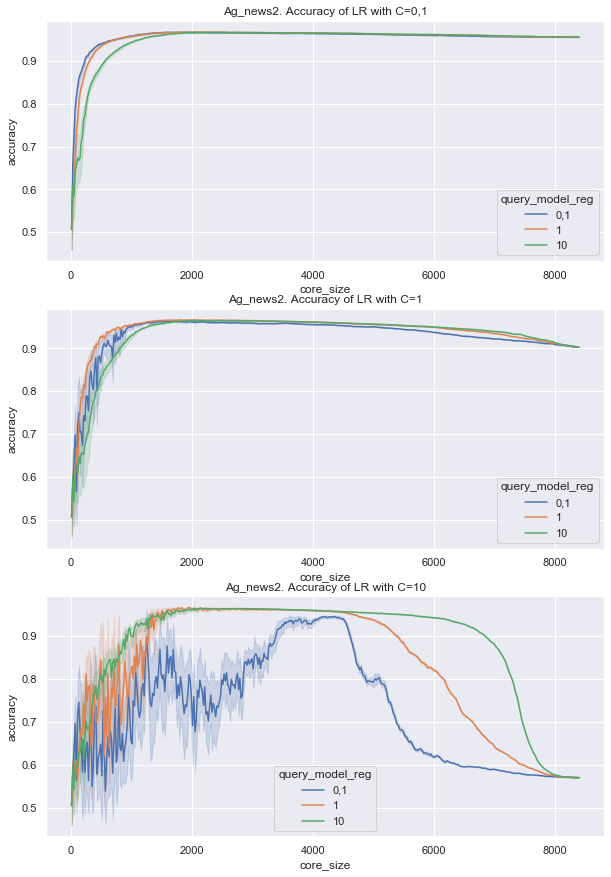

In [128]:
current = df
fig, ax = plt.subplots(3,1, figsize=(10,15))
#current = current[current.query_model == 'Regression']
current = current.melt(['core_size', 'restart', 'query_model'], var_name='model',  value_name='accuracy')
current['regularization_strength'] = current['model'].map(lambda x: reg_map(x))
current['query_model_reg'] = current['query_model'].map(lambda x: reg_map(x))
for i, query_reg in enumerate(['0,1', '1', '10']):
    p = sns.lineplot(x='core_size', y='accuracy', hue='query_model_reg', hue_order=['0,1', '1', '10'], ax=ax[i], data=current[current.regularization_strength == query_reg])
    p.set_title('Ag_news2. Accuracy of LR with C=' + str(query_reg))

bow dbpedia3


Text(0.5, 0, ' ')

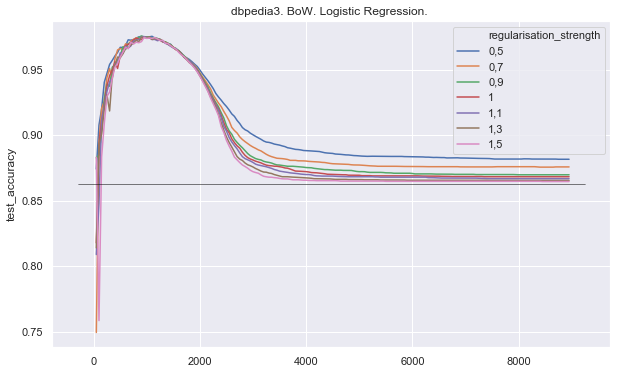

In [39]:
results, datasets, encoders, models = get_data(['bow'], ['dbpedia3'])
gr = group_results(results)
order_ = [str(x).replace('.', ',') for x in [0.5, 0.7, 0.9, 1, 1.1, 1.3, 1.5]]
plt.figure(figsize=(10,6))
sns.set()
dataset = 'dbpedia3'
gr['model_type'] = gr['model'].map(lambda x: 'Regression' if x.startswith('Reg') else 
                                            ('svmSquared' if x.startswith('svmLinear') else 'svm'))
df = gr[(gr.strategy == 'uncertainty sampling') & (gr.dataset == dataset) & (gr.model_type == 'Regression')]
df = df[df.core_size%50==0]
df = df.sort_values('core_size')
if 'downsampled' not in dataset:
    baseline = get_baseline(dataset)
else:
    baseline = get_baseline(dataset[:dataset.index('downsampled') - 1])

#max_difference = df.test_acc.max() - df.test_acc.iloc[-1]

current = df[['core_size', 'encoding', 'model']]
current['test_accuracy'] = df['test_acc']

current['regularization_strength'] = df['model'].map(lambda x: reg_map(x)
#current = current[(current['regularization_strength'] > 0.4) & (current['regularization_strength'] < 2.5)]
sns_plot = sns.lineplot(x='core_size', y='test_accuracy', data=current, hue_order=order_,
                            hue='regularization_strength')

sns_plot.plot([-300, max(df['core_size'])+300], [baseline, baseline], color='black', linewidth=0.5, label='naive baseline')
sns_plot.set_title(dataset + '. BoW. Logistic Regression. ')
sns_plot.set_xlabel(' ')
    #lines = sns_plot.get_lines()
    #lines[5].set_linestyle(':')


In [108]:
results, datasets, encoders, models = get_data(['bow'], ['ag_news2', 'dbpedia3'], ['Regression', 'Regression0,01', 'Regression100', 'Regression0,1', 'Regression10'])
gr = group_results(results)

bow ag_news2
bow dbpedia3


In [112]:
tmp = results[(results.strategy == 'uncertainty sampling') & (results.dataset == 'dbpedia3') & (results.model == 'Regression0,01')]

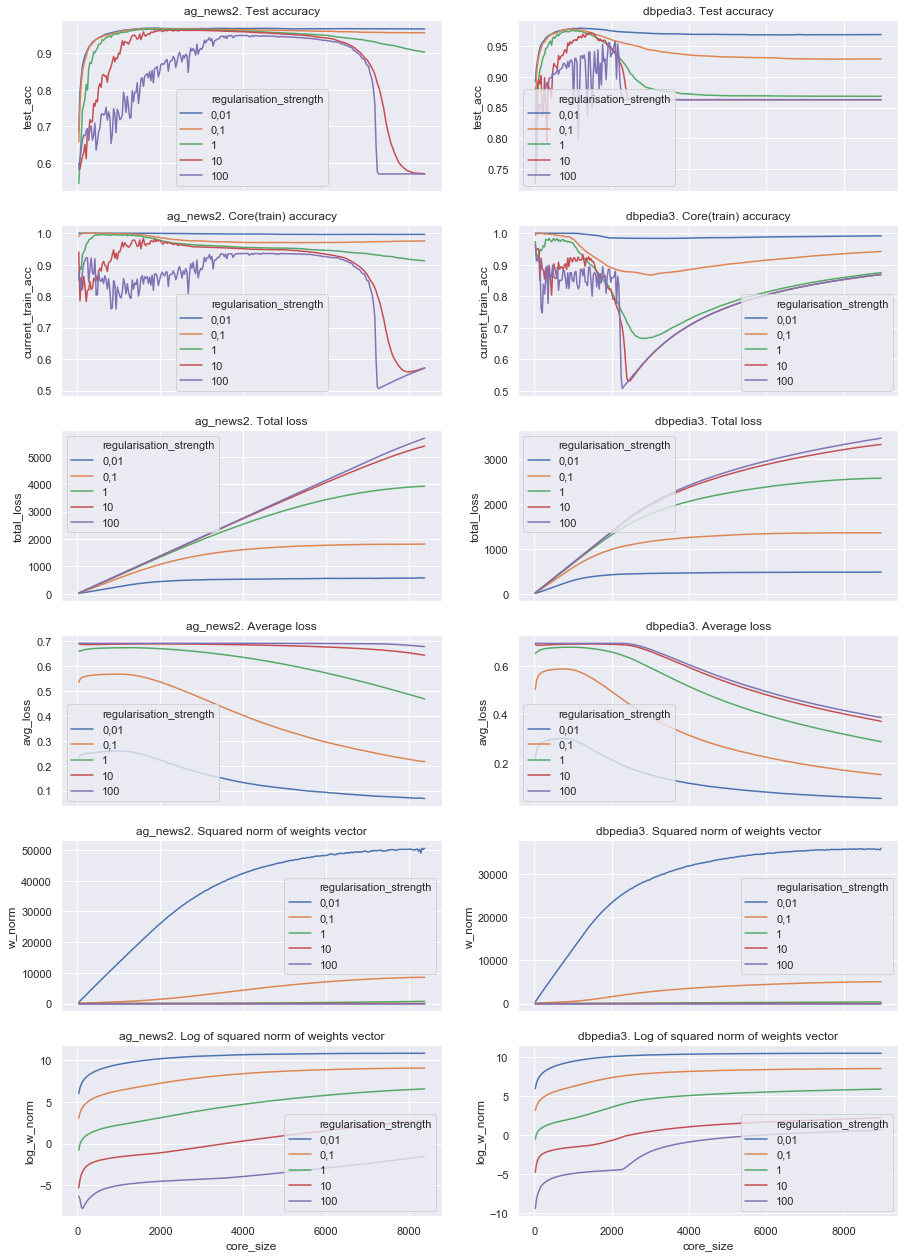

In [118]:

fig, ax = plt.subplots(6, len(datasets), figsize=(15,22), sharex='col')
sns.set()
order_ = [str(x).replace('.', ',') for x in [0.01, 0.1,  1, 10, 100]]
for i, dataset in enumerate(sorted(datasets)):
    df = gr[(gr.strategy == 'uncertainty sampling') & (gr.dataset == dataset)]
    df = df[df.core_size%30==0]
    df = df.sort_values('core_size')
    df['regularization_strength'] = df['model'].map(lambda x: reg_map(x))
    df['log_w_norm'] = np.log(df.w_norm)
    df['avg_loss'] =df['total_loss']/df['core_size']
    sns_plot = sns.lineplot(x='core_size', y='test_acc', data=df, ax=ax[0][i], hue='regularization_strength', hue_order=order_)
    sns_plot.set_title(dataset + '. Test accuracy')
    sns_plot = sns.lineplot(x='core_size', y='current_train_acc', data=df, ax=ax[1][i], hue='regularization_strength', hue_order=order_)
    sns_plot.set_title(dataset + '. Core(train) accuracy')
    sns_plot = sns.lineplot(x='core_size', y='total_loss', data=df, ax=ax[2][i], hue='regularization_strength', hue_order=order_)
    sns_plot.set_title(dataset + '. Total loss')
    sns_plot = sns.lineplot(x='core_size', y='avg_loss', data=df, ax=ax[3][i],  hue='regularization_strength', hue_order=order_)
    sns_plot.set_title(dataset + '. Average loss')
    sns_plot = sns.lineplot(x='core_size', y='w_norm', data=df, ax=ax[4][i], hue='regularization_strength', hue_order=order_)
    sns_plot.set_title(dataset + '. Squared norm of weights vector')
    sns_plot = sns.lineplot(x='core_size', y='log_w_norm', data=df, ax=ax[5][i], hue='regularization_strength', hue_order=order_)
    sns_plot.set_title(dataset + '. Log of squared norm of weights vector')

plt.show()


In [34]:
results, datasets, encoders, models = get_data(['word2vec'], ['cornell-sent-polarity','ag_news3', 'dbpedia3'], ['Regression', 'Regression0,01', 'Regression100', 'Regression0,1', 'Regression10'])
gr = group_results(results)

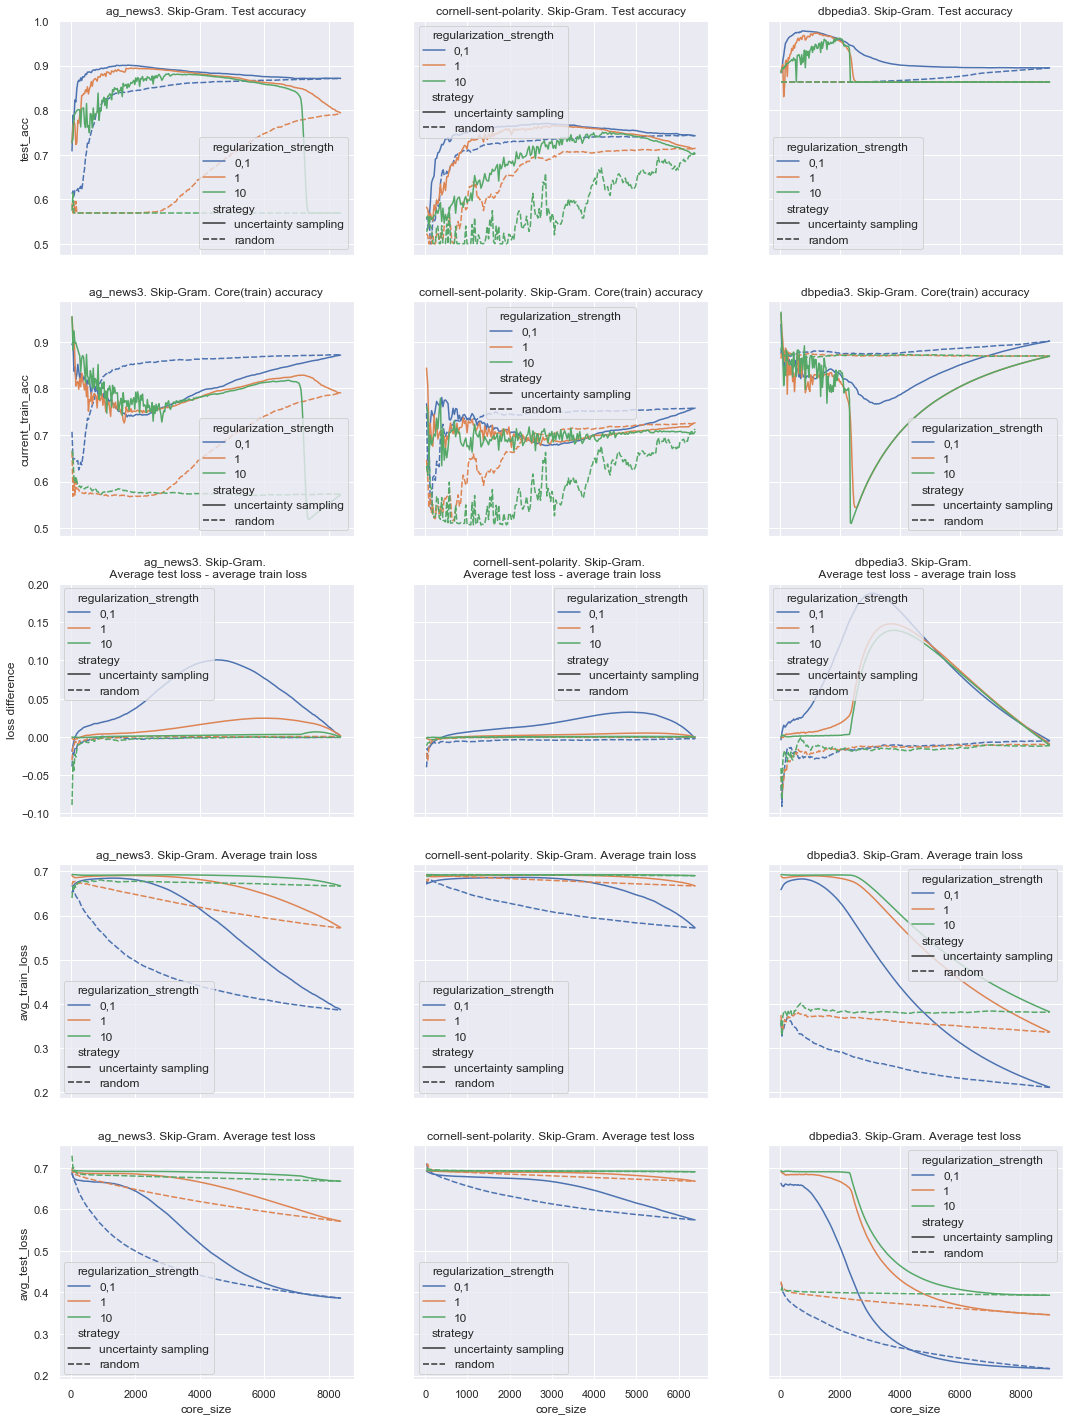

In [35]:

fig, ax = plt.subplots(5, 3, figsize=(18,25), sharex='col', sharey='row')
sns.set()
order_ = [str(x).replace('.', ',') for x in [ 0.1, 1, 10,]]
test_sizes = [5600, 4265, 6000]
for i, dataset in enumerate(sorted(datasets)):
    df = gr[(gr.dataset == dataset)]
    df = df[df.core_size%30==0]
    df['avg_train_loss'] = df['total_loss']/df['core_size']
    df['avg_test_loss'] = df.test_loss/test_sizes[i]
    df['regularization_term'] = df.w_norm * df.regularization_strength.map(lambda x: float(x.replace(',', '.')))
    df['loss_proportion'] = df.total_loss/(df.total_loss + df.regularization_term)
    #df = gr[(gr.strategy == 'uncertainty sampling') & (gr.dataset == dataset)]
    sns_plot = sns.lineplot(x='core_size', y='test_acc', data=df, ax=ax[0][i], hue='regularization_strength', hue_order=order_, style='strategy', style_order=['uncertainty sampling', 'random'])
    sns_plot.set_title(dataset + '. Skip-Gram. Test accuracy')
    sns_plot = sns.lineplot(x='core_size', y='current_train_acc', data=df, ax=ax[1][i], hue='regularization_strength', hue_order=order_, style='strategy', style_order=['uncertainty sampling', 'random'])
    sns_plot.set_title(dataset + '. Skip-Gram. Core(train) accuracy')
    
    df['loss difference'] = df.avg_train_loss -  df.avg_test_loss
    sns_plot = sns.lineplot(x='core_size', y='loss difference', data=df, ax=ax[2][i], hue='regularization_strength', hue_order=order_, style='strategy', style_order=['uncertainty sampling', 'random'])
    sns_plot.set_title(dataset + '. Skip-Gram. \n Average train loss - average test loss')
    
    #current = df.melt(['core_size', 'regularization_strength', 'strategy'], var_name='model',  value_name='accuracy')
    sns_plot = sns.lineplot(x='core_size', y='avg_train_loss', data=df, ax=ax[3][i], hue='regularization_strength', hue_order=order_, style='strategy', style_order=['uncertainty sampling', 'random'])
    sns_plot.set_title(dataset + '. Skip-Gram. Average train loss')
    
    sns_plot = sns.lineplot(x='core_size', y='avg_test_loss', data=df, ax=ax[4][i],  hue='regularization_strength', hue_order=order_, style='strategy', style_order=['uncertainty sampling', 'random'])
    sns_plot.set_title(dataset + '. Skip-Gram. Average test loss')
    

plt.show()


In [27]:
results, datasets, encoders, models = get_data(['bow'], ['cornell-sent-polarity','ag_news3', 'dbpedia3'], ['Regression', 'Regression0,01', 'Regression100', 'Regression0,1', 'Regression10'])
gr = group_results(results)

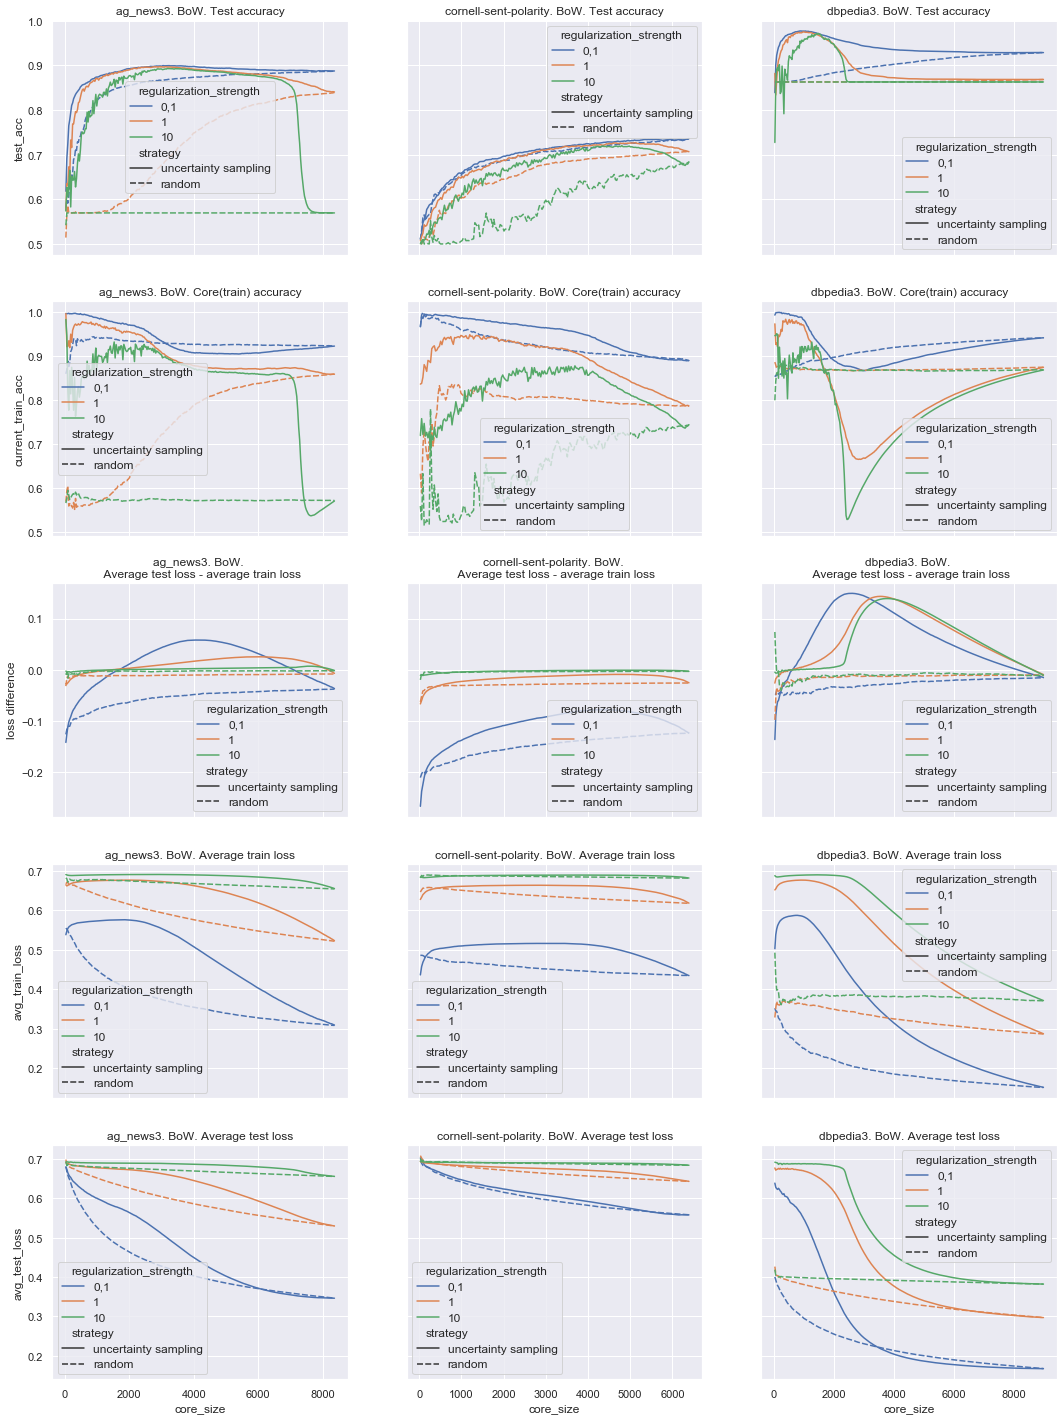

In [33]:

fig, ax = plt.subplots(5, 3, figsize=(18,25), sharex='col', sharey='row')
sns.set()
order_ = [str(x).replace('.', ',') for x in [ 0.1, 1, 10,]]
test_sizes = [5600, 4265, 6000]
for i, dataset in enumerate(sorted(datasets)):
    df = gr[(gr.dataset == dataset)]
    df = df[df.core_size%30==0]
    df['avg_train_loss'] = df['total_loss']/df['core_size']
    df['avg_test_loss'] = df.test_loss/test_sizes[i]
    df['regularization_term'] = df.w_norm * df.regularization_strength.map(lambda x: float(x.replace(',', '.')))
    df['loss_proportion'] = df.total_loss/(df.total_loss + df.regularization_term)
    #df = gr[(gr.strategy == 'uncertainty sampling') & (gr.dataset == dataset)]
    sns_plot = sns.lineplot(x='core_size', y='test_acc', data=df, ax=ax[0][i], hue='regularization_strength', hue_order=order_, style='strategy', style_order=['uncertainty sampling', 'random'])
    sns_plot.set_title(dataset + '. BoW. Test accuracy')
    sns_plot = sns.lineplot(x='core_size', y='current_train_acc', data=df, ax=ax[1][i], hue='regularization_strength', hue_order=order_, style='strategy', style_order=['uncertainty sampling', 'random'])
    sns_plot.set_title(dataset + '. BoW. Core(train) accuracy')
    
    df['loss difference'] = df.avg_train_loss -  df.avg_test_loss
    sns_plot = sns.lineplot(x='core_size', y='loss difference', data=df, ax=ax[2][i], hue='regularization_strength', hue_order=order_, style='strategy', style_order=['uncertainty sampling', 'random'])
    sns_plot.set_title(dataset + '. BoW. \n Average test loss - average train loss')
    
    #current = df.melt(['core_size', 'regularization_strength', 'strategy'], var_name='model',  value_name='accuracy')
    sns_plot = sns.lineplot(x='core_size', y='avg_train_loss', data=df, ax=ax[3][i], hue='regularization_strength', hue_order=order_, style='strategy', style_order=['uncertainty sampling', 'random'])
    sns_plot.set_title(dataset + '. BoW. Average train loss')
    
    sns_plot = sns.lineplot(x='core_size', y='avg_test_loss', data=df, ax=ax[4][i],  hue='regularization_strength', hue_order=order_, style='strategy', style_order=['uncertainty sampling', 'random'])
    sns_plot.set_title(dataset + '. BoW. Average test loss')
    

plt.show()


In [231]:

from sklearn.linear_model import LogisticRegression
from data_loader import load_train_test
dataset = 'cornell-sent-polarity'
encoder = Word2VecEncoder()
for ds in datasets:
    _, X_train, X_test, y_train, y_test = load_train_test(ds, encoder, -1)
    print(y_test.shape, ds)

(5600,) ag_news3
(4265,) cornell-sent-polarity
(6000,) dbpedia3


In [65]:
%%time

from sklearn.linear_model import LogisticRegression
from data_loader import load_train_test
dataset = 'cornell-sent-polarity'
encoder = Word2VecEncoder()
data = []
results, datasets, encoders, models = get_data(['word2vec'], [dataset], ['Regression10'])

results = results[(results.strategy == 'uncertainty sampling')]
_, X_train, X_test, y_train, y_test = load_train_test(dataset, encoder, -1)
model = LogisticRegression(solver='lbfgs', C=10)
model.fit(X_train, y_train)
baseline = model.score(X_test, y_test)
print(baseline)
unc = model.predict_proba(X_train)
unc = np.min(unc, axis=1)
idx = list(range(X_train.shape[0]))

0.7423212192262603
Wall time: 3.47 s


<h3> Downsample viz </h3>

In [119]:
for model in sorted(models):
    if model.endswith('1000'):
        continue
    df = res[(res.model == model) & (res.strategy == 'uncertainty sampling')]
    df_1 = df[df.dataset == 'dbpedia3']
    df_2 = df[df.dataset == 'dbpedia3_downsampled0.7']
    df_3 = df[df.dataset == 'dbpedia3_downsampled0.5']
    p = [df_1.test_acc.max(),df_2.test_acc.max(),df_3.test_acc.max(), df_1.test_acc.iloc[-1],  df_2.test_acc.iloc[-1],  df_3.test_acc.iloc[-1], ]
    print_str = ["{:.1f}".format(x*100) for x in p]
    for index, value in enumerate(p[:3]):
        if value == max(p[:3]):
            print_str[index] = '\cellcolor{green!25}' + print_str[index]
    for index, value in enumerate(p[3:]):
        if value == max(p[3:]):
            print_str[index+3] = '\cellcolor{green!25}' + print_str[index+3]
    
    reg_str = reg_map(model)
    if reg_str == 'L1(C=1)':
        reg_str = 'L1'
    m = 'LR' if model.startswith('Reg') else ('SVC$^2$' if model.startswith('svmLinear') else 'SVC')
    
    print(m + '({})'.format(reg_str),'&', ' & '.join(print_str), '\\\\')
    print('\hline')

LR(1) & \cellcolor{green!25}97.9 & 97.5 & 96.8 & 86.8 & 88.8 & \cellcolor{green!25}90.2 \\
\hline
LR(100) & \cellcolor{green!25}96.0 & 93.8 & 92.2 & 86.3 & 86.3 & \cellcolor{green!25}86.6 \\
\hline
LR(10) & \cellcolor{green!25}97.5 & 96.7 & 95.2 & 86.3 & 86.3 & \cellcolor{green!25}89.0 \\
\hline
LR(0,1) & \cellcolor{green!25}98.0 & 97.6 & 96.6 & 92.9 & \cellcolor{green!25}95.3 & 93.1 \\
\hline
LR(0,01) & \cellcolor{green!25}98.1 & 97.5 & 96.1 & 96.8 & \cellcolor{green!25}97.2 & 95.1 \\
\hline
LR(L1) & \cellcolor{green!25}93.5 & 93.0 & 88.5 & 92.7 & \cellcolor{green!25}92.8 & 88.0 \\
\hline
SVC(1) & \cellcolor{green!25}97.5 & 96.7 & 95.5 & 88.2 & 91.2 & \cellcolor{green!25}92.6 \\
\hline
SVC(100) & 90.7 & \cellcolor{green!25}91.7 & 91.3 & \cellcolor{green!25}86.3 & \cellcolor{green!25}86.3 & 30.5 \\
\hline
SVC(10) & 90.7 & \cellcolor{green!25}91.7 & 91.3 & \cellcolor{green!25}86.3 & \cellcolor{green!25}86.3 & 30.5 \\
\hline
SVC(0,1) & \cellcolor{green!25}98.0 & 97.7 & 96.8 & 96.8 & \cel

In [131]:
results, datasets, encoders, models = get_data(['bow'], ['dbpedia3'])
grouped = group_results(results)

bow dbpedia3


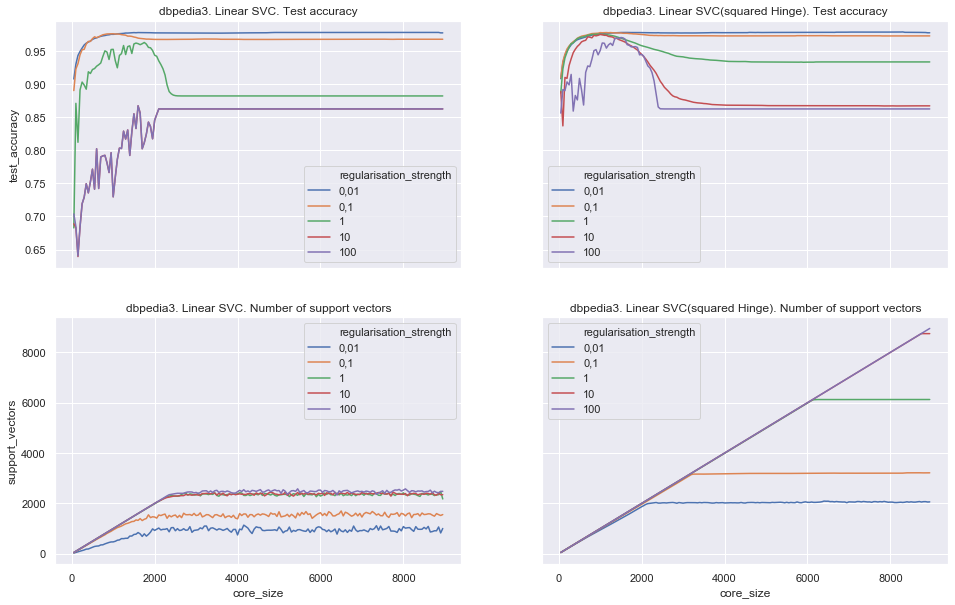

In [141]:
df = grouped[(grouped.strategy == 'uncertainty sampling') & (grouped.dataset == 'dbpedia3')]
df = df[df.core_size%50==0]
df = df.sort_values('core_size')
baseline = get_baseline('dbpedia3')

#max_difference = df.test_acc.max() - df.test_acc.iloc[-1]

current = df[['core_size']]
current['test_accuracy'] = df['test_acc']

current['support_vectors'] = df['support_vectors']
fig, ax = plt.subplots(2,2, figsize=(16,10), sharex='all', sharey='row')
sns_plot = sns.lineplot(x='core_size', y='test_accuracy', data=current[current.model_type == 'svm'],
                        hue='regularization_strength',hue_order=order[:-1], ax=ax[0][0])
sns_plot.set_title('dbpedia3. Linear SVC. Test accuracy')

sns_plot = sns.lineplot(x='core_size', y='support_vectors', data=current[current.model_type == 'svm'],
                        hue='regularization_strength',hue_order=order[:-1], ax=ax[1][0])
sns_plot.set_title('dbpedia3. Linear SVC. Number of support vectors')
lines = sns_plot.get_lines()
lines[-1].set_linestyle(':')


sns_plot = sns.lineplot(x='core_size', y='test_accuracy', data=current[current.model_type == 'svmSquared'],
                        hue='regularization_strength',hue_order=order[:-1], ax=ax[0][1])
sns_plot.set_title('dbpedia3. Linear SVC(squared Hinge). Test accuracy')

sns_plot = sns.lineplot(x='core_size', y='support_vectors', data=current[current.model_type == 'svmSquared'],
                        hue='regularization_strength',hue_order=order[:-1], ax=ax[1][1])
sns_plot.set_title('dbpedia3. Linear SVC(squared Hinge). Number of support vectors')
lines = sns_plot.get_lines()
lines[5].set_linestyle(':')

<h3> Big viz </h3>

In [7]:

results = get_data(['bow'], BIG_DATASETS + ALL_DATASETS[2:])
datasets = sorted(results.dataset.unique())
encoders = results.encoding.unique()
models = results.model.unique()
print(datasets, encoders, models)
grouped_bow = results.groupby(['core_size', 'strategy', 'dataset', 'model']).mean().reset_index()
grouped_bow.head()

bow ag_news2_big
bow ag_news3_big
bow dbpedia3_big
bow dbpedia8_big
bow ag_news2
bow ag_news3
bow dbpedia3
bow dbpedia8
['ag_news2', 'ag_news2_big', 'ag_news3', 'ag_news3_big', 'dbpedia3', 'dbpedia3_big', 'dbpedia8', 'dbpedia8_big'] ['bow'] ['Regression' 'svmHinge' 'svmLinear' 'Regression0,01' 'Regression0,1'
 'Regression10' 'Regression100' 'Regression1000' 'RegressionL1'
 'svmHinge0,01' 'svmHinge0,1' 'svmHinge10' 'svmHinge100' 'svmLinear0,01'
 'svmLinear0,1' 'svmLinear10' 'svmLinear100' 'svmLinear1000' 'svmLinearL1']


core_size algorithm   dataset       model  test_acc  ask_id  \
0       10.0    random  ag_news2  Regression  0.506679    -1.0   
1       10.0    random  ag_news2   svmLinear  0.507179    -1.0   
2       10.0    random  ag_news3  Regression  0.499786    -1.0   
3       10.0    random  ag_news3   svmLinear  0.500268    -1.0   
4       10.0    random  dbpedia3  Regression  0.862833    -1.0   

   current_train_acc  remaining_train_acc  support_vectors  certainty  
0               0.71             0.506889             -1.0   0.659890  
1               0.71             0.507354             -1.0   0.575279  
2               0.71             0.499178             -1.0   0.660129  
3               0.72             0.499845             -1.0   0.573784  
4               0.84             0.869255             -1.0   0.839536

ag_news2 0.060506748352641714 16.52708213919977
ag_news3 0.05946270223568107 16.81726464492799
dbpedia3 0.06120792547926875 16.337753520803478
dbpedia8 0.06395030614020362 15.63714171762706


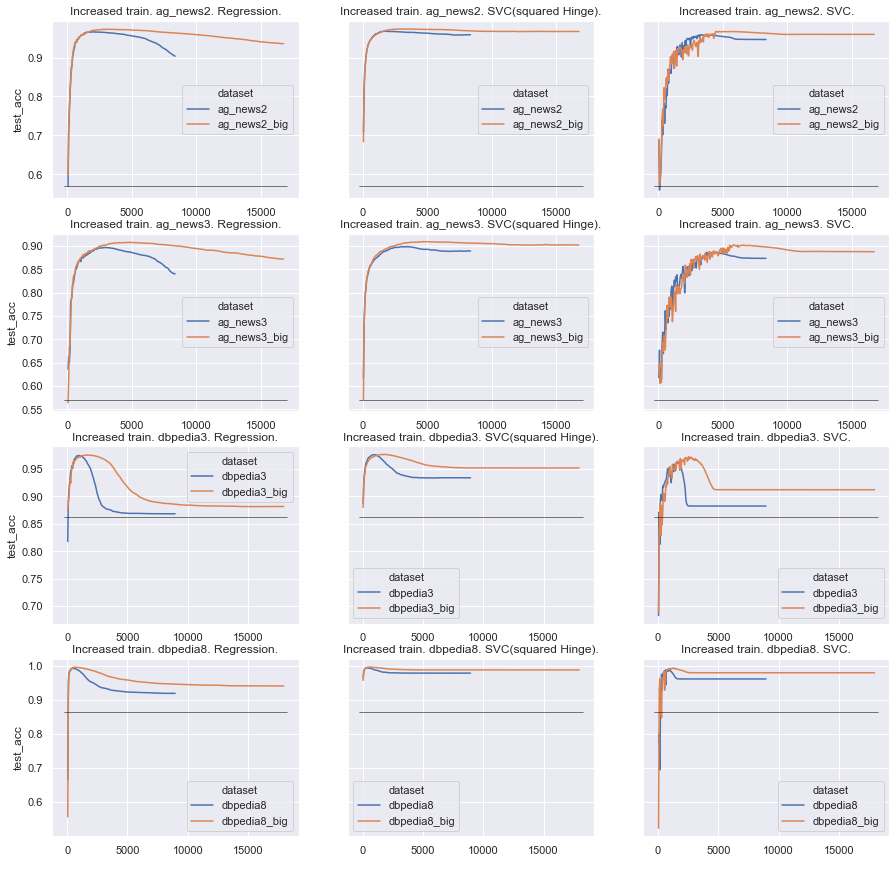

In [13]:
sns.set()
fig, ax = plt.subplots(ncols=3, nrows=4, figsize=(15,15), sharey='row')
for j, dataset in enumerate(ALL_DATASETS[2:]):
    current = grouped_bow[(grouped_bow.strategy == 'uncertainty sampling') & ((grouped_bow.dataset == dataset) | (grouped_bow.dataset == dataset+'_big'))]
    
    baseline = get_baseline(dataset)
    for i, model in enumerate(['Regression', 'svmLinear', 'svmHinge']):
        df = current[current.model == model]
        df = df[df.core_size%50==0]
        p = sns.lineplot(data=df, x='core_size', y='test_acc', hue='dataset', ax=ax[j][i])
        if model.startswith('svm'):
            model = 'SVC(squared Hinge)' if model == 'svmLinear' else 'SVC'
        p.set_title('Increased train. {}. {}.'.format(dataset, model))
        p.plot([-300, max(df['core_size'])+300], [baseline, baseline], color='black', linewidth=0.5)
        p.set_xlabel(' ')

0.769284876905041
Wall time: 417 ms


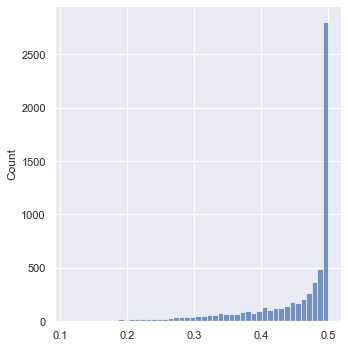

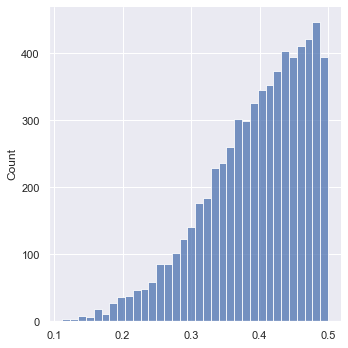

In [68]:
%%time
for i,temperature in enumerate([]):
    for size in [2000, 3000, 4000]:
        p = [np.exp(unc*t) for t in temps]
        p = [x/sum(x) for x in p]
        r = []
        for restart in range(100):
            sampled_subset = np.random.RandomState(restart+size+temperature*10000).choice(idx, size=size, replace=False, p=p[i])
            model.fit(X_train[sampled_subset], y_train[sampled_subset])
            r.append(model.score(X_test, y_test))
        print(size, temperature, np.mean(r))

r = []
for restart in range(1):
    random = np.random.RandomState(restart)
    idx = random.choice(len(y_train), 10, False)
    while len(set(y_train[idx])) == 1:
        idx = random.choice(len(y_train), 10, False)
    history = np.hstack([idx, results[(results.restart == str(restart))].ask_id.values.astype('int')])
    history_unc = np.hstack([[0.5]*10, 1-results[(results.restart == str(restart))].certainty.values])
    model.fit(X_train[history[:3000]], y_train[history[:3000]])
    r.append(model.score(X_test, y_test))
print(np.mean(r))
sns.displot(history_unc)
sns.displot(unc)

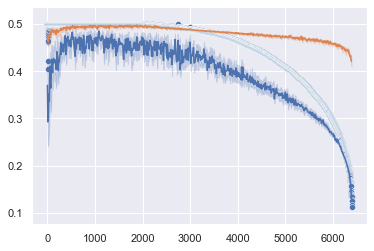

In [78]:
p = sns.lineplot(x=list(range(len(history_unc))), y=history_unc)
p = sns.lineplot(x=[(y//10)*10 for y in range(len(history_unc))], y=unc[history], ax=p)
unc2 = model.predict_proba(X_train)
unc2 = np.min(unc2, axis=1)
p = sns.lineplot(x=[(y//10)*10 for y in range(len(history_unc))], y=unc2[history], ax=p)

In [65]:
CREATE_META = False
if CREATE_META:
    metadata = {}
    for ds in os.listdir('../results/pmlb/') + os.listdir('../results/pmlb_small/'):
        X, y = fetch_data(ds, return_X_y=True, local_cache_dir='../experiment_data/plmb/')
        n_classes = len(set(y))
        if X.shape[0] > 15000:
            idx = np.random.RandomState(10).choice(list(range(X.shape[0])), 15000, replace=False)
            X = X[idx]
            y = y[idx]
        if n_classes != 2:
            c = Counter(y)
            positive = sorted(c.keys(), key=lambda x: c[x])[-1]
            y = np.array([x == positive for x in y])
        prop = sum(y)/len(y)
        prop = max(prop, 1-prop)
        metadata[ds] = (prop, n_classes)
    with open('../experiment_data/meta.pkl', 'wb') as f:
        pickle.dump(metadata, f)
else:
    with open('../experiment_data/meta.pkl', 'rb') as f:
        metadata = pickle.load(f)

0.014117447791927211
0.00895078216407775
0.004017595588914115
1.2169576380758606e-07
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [10]:
def get_table(enc):
    results, datasets, encoders, models = get_data([enc])
    for i, dataset in enumerate(sorted(datasets)):
        df = results[(results.strategy == 'uncertainty sampling') & (results.dataset == dataset) & (results.model == 'Regression')]
        difference = df.test_acc.max() - df.test_acc.iloc[-1]
        final = df.test_acc.iloc[-1]
        error_reduction = difference/(1-final)
        if np.isnan(error_reduction):
            error_reduction = 0
        df = results[(results.strategy == 'random') & (results.dataset == dataset) & (results.model == 'Regression')]
        random_difference = df.test_acc.max() - df.test_acc.iloc[-1]
        v = '25'
        color = 'white'
        if final > 0.995:
            color = 'gray'
        elif random_difference >= 0.5*difference:
            color = 'red'
        elif random_difference > 0.33*difference:
            color = 'yellow'
        elif error_reduction > 0.095:
            color='green'


        s = '\\rowcolor{' + color + '!10}' + ' & '.join([dataset.replace('_', ' ')] + [str(round(x*100, 2)) if type(x) != str else x for x in [get_baseline(dataset), final, difference, random_difference, error_reduction, ]])
        print(s + ' \\\\')
        print('\hline')

In [11]:
get_table('pmlb')

\rowcolor{red!10}adult & 75.95 & 85.1 & 0.33 & 0.3 & 2.24 \\
\hline
\rowcolor{gray!10}agaricus lepiota & 51.91 & 100.0 & 0.0 & 0.0 & 0 \\
\hline
\rowcolor{green!10}ann thyroid & 92.58 & 95.62 & 2.6 & 0.03 & 59.52 \\
\hline
\rowcolor{green!10}clean2 & 84.59 & 94.66 & 0.53 & 0.15 & 9.93 \\
\hline
\rowcolor{red!10}coil2000 & 94.03 & 93.64 & 0.33 & 0.28 & 5.2 \\
\hline
\rowcolor{yellow!10}connect 4 & 66.25 & 79.32 & 0.67 & 0.25 & 3.22 \\
\hline
\rowcolor{gray!10}fars & 58.25 & 99.93 & 0.0 & 0.0 & 0.0 \\
\hline
\rowcolor{gray!10}kddcup & 57.52 & 99.85 & 0.03 & 0.0 & 22.22 \\
\hline
\rowcolor{green!10}krkopt & 83.63 & 83.97 & 3.18 & 0.48 & 19.85 \\
\hline
\rowcolor{green!10}letter & 95.93 & 97.25 & 0.37 & 0.05 & 13.33 \\
\hline
\rowcolor{yellow!10}magic & 64.66 & 79.07 & 0.9 & 0.4 & 4.3 \\
\hline
\rowcolor{red!10}mnist & 89.09 & 89.18 & 0.0 & 0.0 & 0.0 \\
\hline
\rowcolor{gray!10}mushroom & 51.8 & 100.0 & 0.0 & 0.0 & 0 \\
\hline
\rowcolor{gray!10}nursery & 66.66 & 100.0 & 0.0 & 0.0 & 0 \\
\h

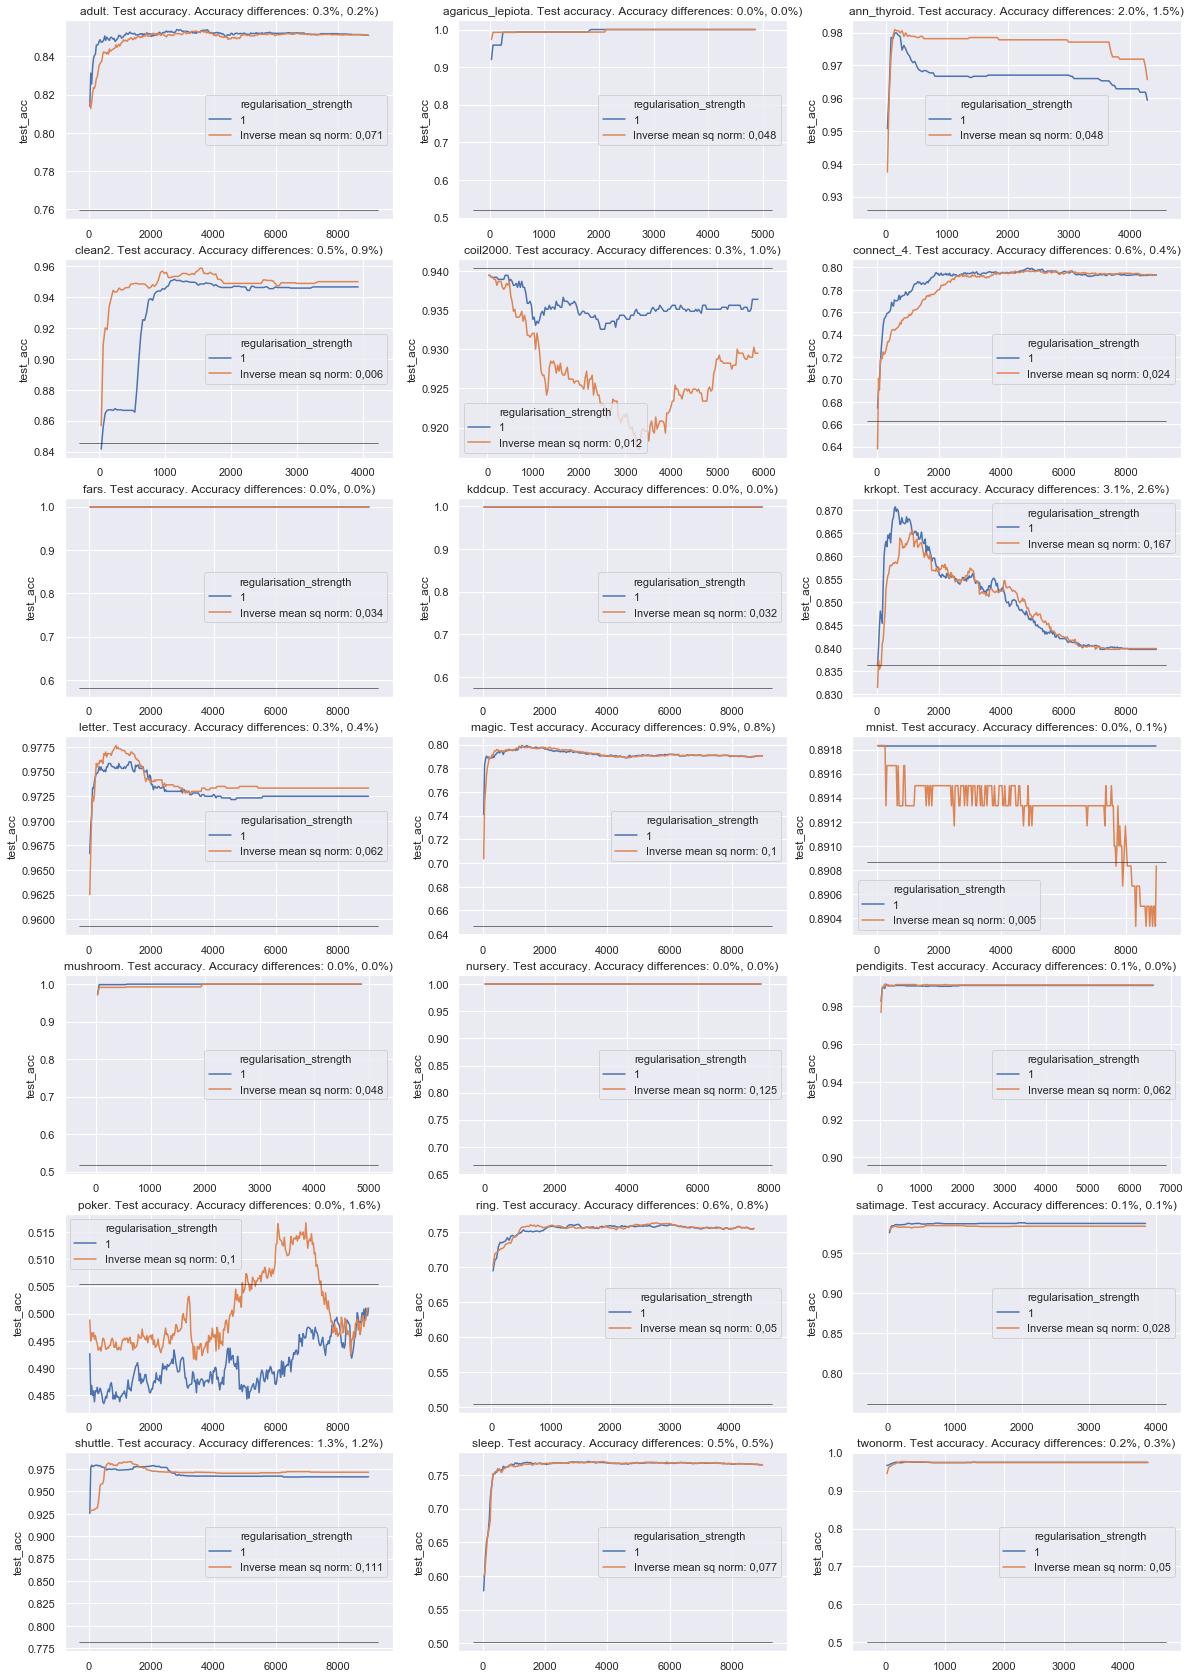

In [14]:
results, datasets, encoders, models = get_data(['pmlb'])
n = len(datasets)
fig, ax = plt.subplots(n//3 , 3, figsize=(20,30))
sns.set()
order_ = ['1/||w||^2', '1']
for i, dataset in enumerate(sorted(datasets)):
    df = results[(results.strategy == 'uncertainty sampling') & (results.dataset == dataset)]
    df = df[df.core_size%30==0]
    df = df.sort_values('core_size')
    df['regularization_strength'] = df['model'].map(lambda x: '1' if reg_map(x) == '1' else 'Inverse mean sq norm: ' + reg_map(x))
    sns_plot = sns.lineplot(x='core_size', y='test_acc', data=df, ax=ax[i//3][i%3], hue='regularization_strength')
    sns_plot.set_xlabel('')
    max_difference = []
    for reg in sorted(df.regularization_strength.unique()):
        max_difference.append(df[df.regularization_strength == reg].test_acc.max() - df[df.regularization_strength == reg].test_acc.iloc[-1])
        #sns_plot.text(sns_plot.get_xlim()[1]//4,sns_plot.get_ylim()[1]*0.95,'Difference between peak and final: {:.1f}%'.format(max_difference*100))

    sns_plot.set_title(dataset + '. Test accuracy. Accuracy differences: {:.1f}%, {:.1f}%)'.format(max_difference[0]*100, max_difference[1]*100))
    
    baseline = metadata[dataset][0]
    sns_plot.plot([-300, max(df['core_size'])+300], [baseline, baseline], color='black', linewidth=0.5, label='naive baseline')
    

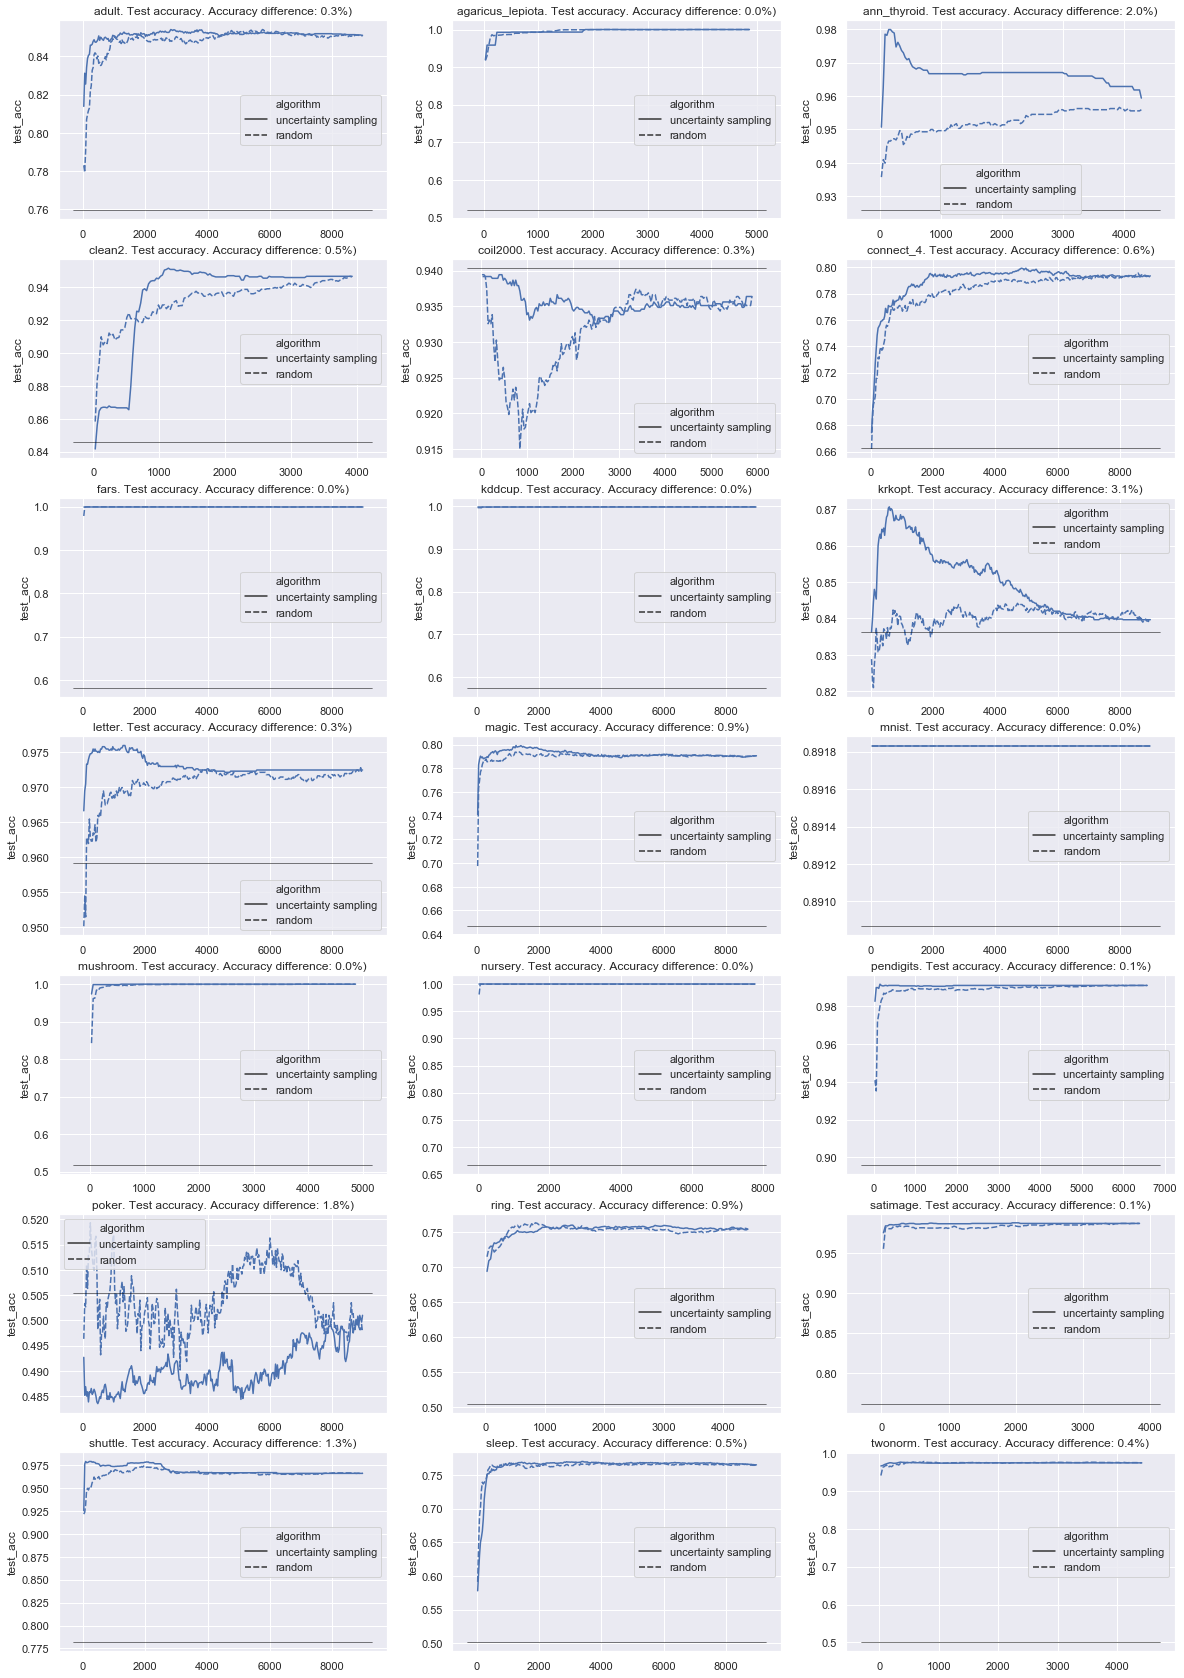

In [15]:

n = len(datasets)
fig, ax = plt.subplots(n//3 , 3, figsize=(20,30))
sns.set()
order_ = ['1/||w||^2', '1']
for i, dataset in enumerate(sorted(datasets)):
    df = results[(results.model == 'Regression') & (results.dataset == dataset)]
    df = df[df.core_size%30==0]
    df = df.sort_values('core_size')
    df['regularization_strength'] = df['model'].map(lambda x: '1' if reg_map(x) == '1' else 'Inverse mean sq norm: ' + reg_map(x))
    sns_plot = sns.lineplot(x='core_size', y='test_acc', data=df, ax=ax[i//3][i%3], style='strategy', style_order=['uncertainty sampling', 'random'])
    sns_plot.set_xlabel('')
    max_difference = df[df.regularization_strength == '1'].test_acc.max() - df[df.regularization_strength == '1'].test_acc.iloc[-1]
        #sns_plot.text(sns_plot.get_xlim()[1]//4,sns_plot.get_ylim()[1]*0.95,'Difference between peak and final: {:.1f}%'.format(max_difference*100))

    sns_plot.set_title(dataset + '. Test accuracy. Accuracy difference: {:.1f}%)'.format(max_difference*100))
    
    baseline = metadata[dataset][0]
    sns_plot.plot([-300, max(df['core_size'])+300], [baseline, baseline], color='black', linewidth=0.5, label='naive baseline')
    

In [146]:
df = pd.read_csv('../experiment_data/all_summary_stats.tsv', delimiter='\t')
df[(df.endpoint_type == 'categorical') & (df.n_instances > 2000) & (df.n_instances < 6000)]

dataset  n_instances  n_features  n_binary_features  \
130               allbp         3772          29                 19   
131            allhyper         3771          29                 19   
132             allhypo         3770          29                 19   
133              allrep         3772          29                 19   
167               chess         3196          36                 35   
168               churn         5000          20                  2   
188                 dis         3772          29                 19   
189                 dna         3186         180                180   
206         hypothyroid         3163          25                 17   
211            kr_vs_kp         3196          36                 35   
214               led24         3200          24                 24   
215                led7         3200           7                  7   
237           optdigits         5620          64                  0   
238         page_blocks         5473          10                  0   
243             phoneme         5404           5                  0   
255        segmentation         2310          19                  0   
262            spambase         4601          57                  0   
265              splice         3188          60                  0   
267             texture         5500          40                  0   
276         waveform_21         5000          21                  0   
277         waveform_40         5000          40                  0   
280  wine_quality_white         4898          11                  0   

     n_categorical_features  n_continuous_features endpoint_type  n_classes  \
130                      10                      0   categorical        3.0   
131                      10                      0   categorical        4.0   
132                      10                      0   categorical        3.0   
133                      10                      0   categorical        4.0   
167                       1                      0   categorical        2.0   
168                       2                     16   categorical        2.0   
188                      10                      0   categorical        2.0   
189                       0                      0   categorical        3.0   
206                       8                      0   categorical        2.0   
211                       1                      0   categorical        2.0   
214                       0                      0   categorical       10.0   
215                       0                      0   categorical       10.0   
237                       0                     64   categorical       10.0   
238                       0                     10   categorical        5.0   
243                       0                      5   categorical        2.0   
255                       0                     19   categorical        7.0   
262                       2                     55   categorical        2.0   
265                      60                      0   categorical        3.0   
267                       0                     40   categorical       11.0   
276                       0                     21   categorical        3.0   
277                       0                     40   categorical        3.0   
280                       0                     11   categorical        7.0   

     imbalance            task  
130   0.875523  classification  
131   0.930142  classification  
132   0.783766  classification  
133   0.914274  classification  
167   0.001974  classification  
168   0.514376  classification  
188   0.939440  classification  
189   0.077685  classification  
206   0.818158  classification  
211   0.001974  classification  
214   0.000189  classification  
215   0.000436  classification  
237   0.000015  classification  
238   0.762710  classification  
243   0.170592  classification  
255   0.000000  classification  
262

In [147]:
ds

array(['allbp', 'allhyper', 'allhypo', 'allrep', 'chess', 'churn', 'dis',
       'dna', 'hypothyroid', 'kr_vs_kp', 'led24', 'led7', 'optdigits',
       'page_blocks', 'phoneme', 'segmentation', 'spambase', 'splice',
       'texture', 'waveform_21', 'waveform_40', 'wine_quality_white'],
      dtype=object)

In [148]:

for dataset in os.listdir('../experiment_data/plmb/'):
    shutil.copy('../experiment_data/datasets/' + dataset +'/metadata.yaml', '../experiment_data/plmb/' + dataset +'/metadata.yaml')

In [77]:
current = grouped[grouped.model == 'Regression'].reset_index().set_index(['dataset'])
for ds in datasets:
    sns.set()
    plt.figure(figsize=(15,7))
    df = current.loc[ds]
    sns_plot = sns.lineplot(x='core_size', y='accuracy', 
                            hue='encoding',hue_order=['glove', 'fasttext', 'skip-gram', 'cbow', 'bow'], 
                            data=df, size='strategy', size_order=['random', 'uncertaincy sampling'], sizes=(2.5,0.7))
    #sns_plot.set_title(ds)
    print(ds)
    #sns_plot.set
    sns_plot.get_figure().savefig(ds+'_all.png')

cornell-sent-polarity (10662, 2)
cornell-sent-subjectivity (9903, 2)


In [ ]:
sizes = grouped[grouped.model == 'Regression'].reset_index().groupby(['dataset']).max()['core_size']

for ds in datasets:
    for enc in encoders:
        print(grouped[(grouped.dataset == ds) & (grouped.encoding == enc) & (grouped.core_size == sizes[ds])][['dataset', 'encoding', 'accuracy']])

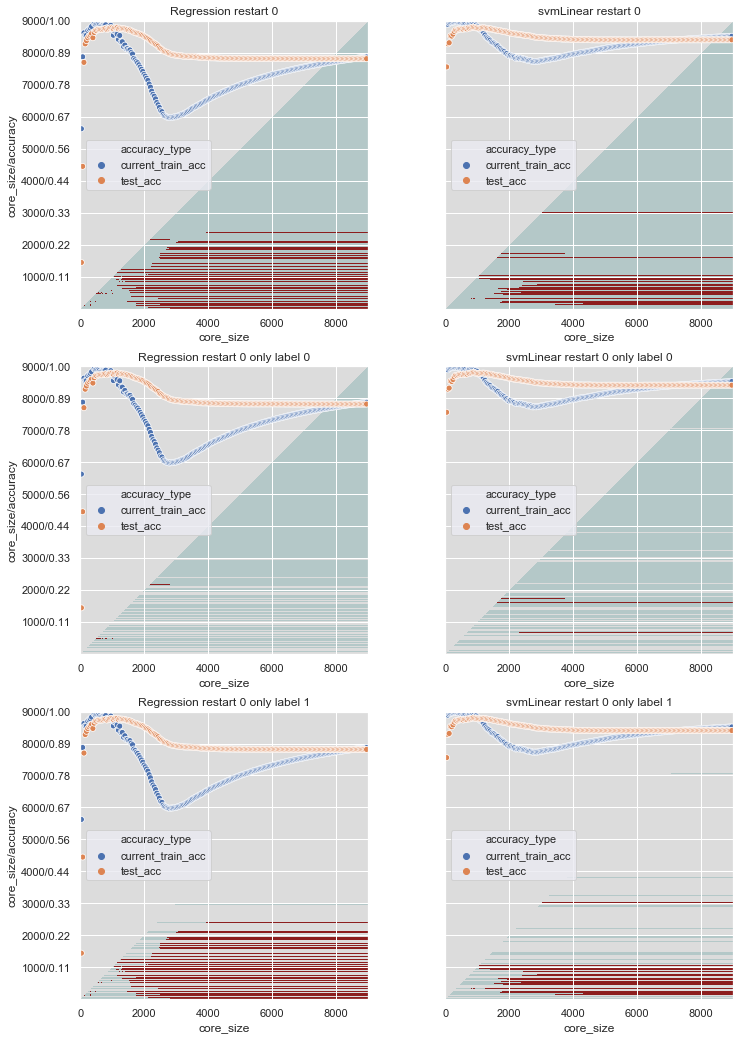

In [369]:


COLORS = [np.array([220, 220, 220], dtype=np.uint8), np.array([140,30,30], dtype=np.uint8),np.array([180,200,200], dtype=np.uint8) ] 
GRAY = [220, 220, 220]
fig, ax = plt.subplots(3, 2, figsize=(12,18), sharey='row')
dataset, restart = 'dbpedia3', 0
c_models = ['Regression', 'svmLinear']
for j, model in enumerate(c_models):
    backup_path = 'results/bow/{}/backup_{}_{}.pkl'.format(dataset, restart , model)

    sns.set()
    if not os.path.exists(backup_path):
        with open('results/bow/{}/unc_{}_{}.pkl'.format(dataset, restart , model), 'rb') as f:
            data = pickle.load(f)
        N = len(data)
        row_to_id = {i: x for i,x in enumerate(sorted(data.keys(), key=lambda z: len(data[z]), reverse=True))}
        array = []
        for x in sorted(data.values(), key=lambda z: len(z)):
            r = [-1]*(N - len(x)) + x
            r = [COLORS[y+1] for y in r]
            array.append(r)
        image_array = np.array(array, dtype=np.uint8)
        with open(backup_path, 'wb') as f:
            pickle.dump(image_array, f)
    else:
        with open(backup_path, 'rb') as f:
            image_array = pickle.load(f)
        with open('results/bow/{}/unc_{}_{}.pkl'.format(dataset, restart , model), 'rb') as f:
            data = pickle.load(f)
        N = len(data)
        row_to_id = {i: x for i,x in enumerate(sorted(data.keys(), key=lambda z: len(data[z]), reverse=True))}

    y_train = get_labels(dataset)
    row_labels = np.array([y_train[row_to_id[i]] for i in range(len(row_to_id)-1, -1, -1)], dtype=bool)


    current_df = results[(results.model == model) & (results.dataset == dataset) & (results.restart == str(restart)) & (results.strategy == 'uncertainty sampling')]
    current_df = current_df[current_df.core_size%40 == 0]
    current = current_df[['core_size', 'current_train_acc', 'test_acc']].melt('core_size', var_name='accuracy_type',  value_name='core_size/accuracy')
    current['core_size/accuracy'] = N - current['core_size/accuracy']*N
    for i in range(3):
        sns.scatterplot('core_size', 'core_size/accuracy', data=current, hue='accuracy_type', ax=ax[i][j])
        if i == 0:
            img = Image.fromarray(image_array)
            ax[i][j].imshow(img)
            ax[i][j].set_title(model + ' restart ' + str(restart))
        elif i == 1:
            new_img = np.array(image_array)
            new_img[row_labels] = GRAY
            ax[i][j].imshow(Image.fromarray(new_img))
            ax[i][j].set_title(model + ' restart ' + str(restart) + ' only label 0')
        else:
            new_img = np.array(image_array)
            new_img[~row_labels] = GRAY
            ax[i][j].imshow(Image.fromarray(new_img))
            ax[i][j].set_title(model + ' restart ' + str(restart) + ' only label 1')

        labels = [str(int(N - x)) + '/' + "{:.2f}".format((N-x)/N) for x in ax[i][j].get_xticks()]
        ax[i][j].set_yticklabels(labels)
        #ax[i][j].set_xticklabels([int(x) for x in ax[i][j].get_xticks()])
        ax[i][j].legend(loc='center left')
plt.show()

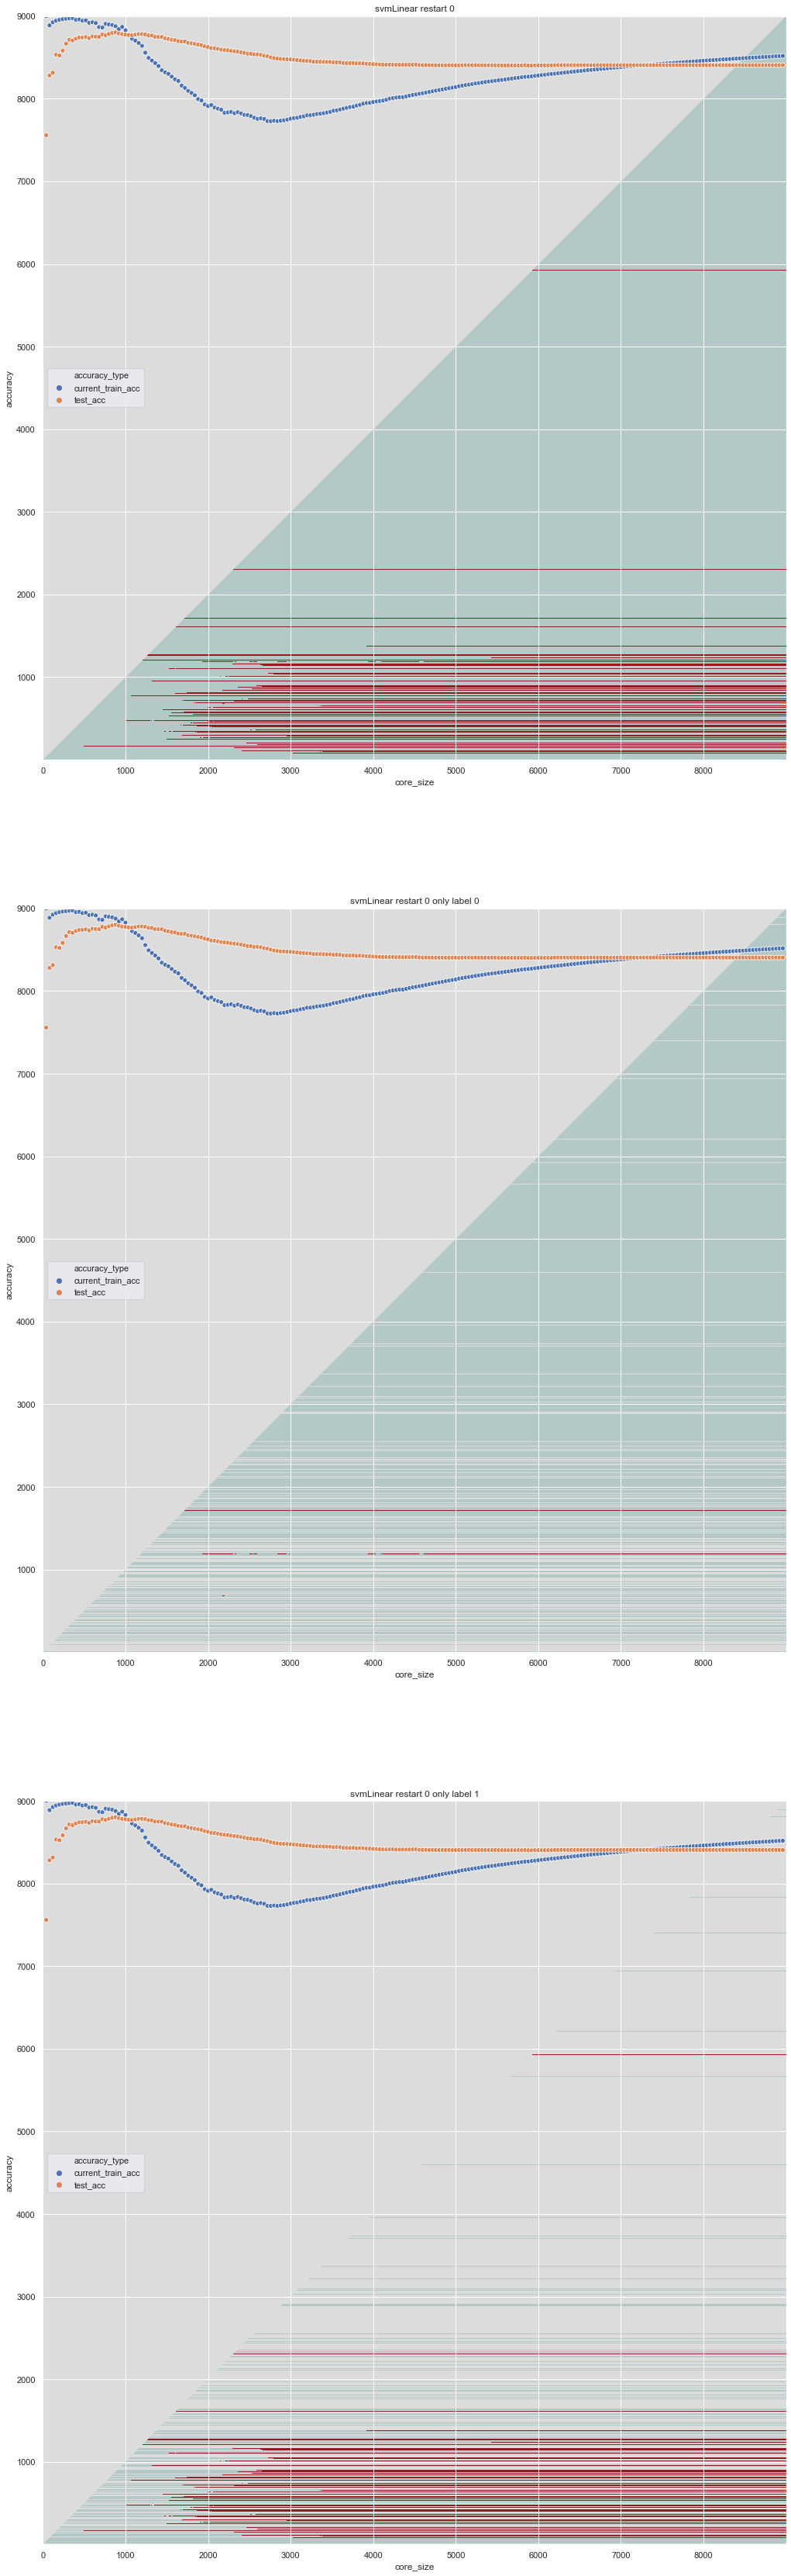

In [235]:

triangle_viz(results, 'dbpedia3', 'svmLinear', 0)

In [46]:

results, datasets, encoders, models = get_data(['word2vec'], ['cornell-sent-polarity'], ['Regression'])

In [51]:
gr = group_results(results)
gr[ (gr.core_size % 1000 == 0)]

core_size             algorithm                dataset       model  \
1980      1000.0                random  cornell-sent-polarity  Regression   
1981      1000.0  uncertainty sampling  cornell-sent-polarity  Regression   
3980      2000.0                random  cornell-sent-polarity  Regression   
3981      2000.0  uncertainty sampling  cornell-sent-polarity  Regression   
5980      3000.0                random  cornell-sent-polarity  Regression   
5981      3000.0  uncertainty sampling  cornell-sent-polarity  Regression   
7980      4000.0                random  cornell-sent-polarity  Regression   
7981      4000.0  uncertainty sampling  cornell-sent-polarity  Regression   
9980      5000.0                random  cornell-sent-polarity  Regression   
9981      5000.0  uncertainty sampling  cornell-sent-polarity  Regression   
11980     6000.0                random  cornell-sent-polarity  Regression   
11981     6000.0  uncertainty sampling  cornell-sent-polarity  Regression   

        encoding  model_type regularisation_strength  test_acc  ask_id  \
1980   skip-gram  Regression                       1  0.533529  3834.8   
1981   skip-gram  Regression                       1  0.724478  4176.2   
3980   skip-gram  Regression                       1  0.649426  3894.0   
3981   skip-gram  Regression                       1  0.744807  3526.5   
5980   skip-gram  Regression                       1  0.691512  2919.4   
5981   skip-gram  Regression                       1  0.765463  5015.2   
7980   skip-gram  Regression                       1  0.706823  3241.0   
7981   skip-gram  Regression                       1  0.758898  4187.6   
9980   skip-gram  Regression                       1  0.710574  3352.0   
9981   skip-gram  Regression                       1  0.745346  3420.1   
11980  skip-gram  Regression                       1  0.712802  3956.5   
11981  skip-gram  Regression                       1  0.721571  3709.9   

       current_train_acc  remaining_train_acc  support_vectors     w_norm  \
1980            0.553700             0.530220              0.0   2.469805   
1981            0.721300             0.731555              0.0   1.542114   
3980            0.660900             0.647464              0.0   9.389777   
3981            0.672400             0.791562              0.0   2.138651   
5980            0.697567             0.689815              0.0  19.723492   
5981            0.689567             0.866559              0.0   2.730575   
7980            0.713825             0.710013              0.0  33.923905   
7981            0.698350             0.907176              0.0   5.897611   
9980            0.720140             0.713457              0.0  51.248507   
9981            0.708000             0.927917              0.0  17.384886   
11980           0.722867             0.721159              0.0  71.387894   
11981           0.716667             0.976574              0.0  49.123156   

        total_loss  avg_loss  certainty  
1980    687.539939        -1   0.517242  
1981    690.043928        -1   0.500001  
3980   1366.827935        -1   0.508793  
3981   1381.991899        -1   0.500001  
5980   2038.618224        -1   0.512797  
5981   2073.952422        -1   0.501121  
7980   2702.016468        -1   0.513005  
7981   2760.702737        -1   0.504203  
9980   3358.373434        -1   0.512343  
9981   3430.399535        -1   0.512355  
11980  4008.231341        -1   0.518055  
11981  4056.815173        -1   0.535083